# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [2]:
# import needed python libraries

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import torch # type: ignore
import torch.nn.functional as F
import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly

from plotly.subplots import make_subplots
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils._testing import ignore_warnings
from art.estimators.classification import PyTorchClassifier # type: ignore
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent # type: ignore
from collections import Counter # To do counter of some features
from torch import nn
from imblearn.over_sampling import SMOTE # type: ignore

#### this code, allow us to work with offline plotly version
py.init_notebook_mode(connected=True) 

#### to avoid some redundant warning during cross-validation due to parameters incompatibility and also eventual packets'versions mismatch
import warnings
warnings.filterwarnings('ignore')



# 1 Data exploration and preprocessing

### 1.1 Dataset Acquisition ###

---
Begin by downloading the [German Credit Risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

In [3]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)
df

Status_account  Duration Credit_history Purpose  Credit_amount  \
0              A11         6            A34     A43           1169   
1              A12        48            A32     A43           5951   
2              A14        12            A34     A46           2096   
3              A11        42            A32     A42           7882   
4              A11        24            A33     A40           4870   
..             ...       ...            ...     ...            ...   
995            A14        12            A32     A42           1736   
996            A11        30            A32     A41           3857   
997            A14        12            A32     A43            804   
998            A11        45            A32     A43           1845   
999            A12        45            A34     A41           4576   

    Savings_account_bonds Employment_since  Install_rate Personal_status_sex  \
0                     A65              A75             4                 A93   
1                     A61              A73             2                 A92   
2                     A61              A74             2                 A93   
3                     A61              A74             2                 A93   
4                     A61              A73             3                 A93   
..                    ...              ...           ...                 ...   
995                   A61              A74             3                 A92   
996                   A61              A73             4                 A91   
997                   A61              A75             4                 A93   
998                   A61              A73             4                 A93   
999                   A62              A71             3                 A93   

    debtors_guarantors  ...  Property Age  Other_install_plans Housing  \
0                 A101  ...      A121  67                 A143    A152   
1                 A101  ...      A121  22                 A143    A152   
2                 A101  ...      A121  49                 A143    A152   
3                 A103  ...      A122  45                 A143    A153   
4                 A101  ...      A124  53                 A143    A153   
..                 ...  ...       ...  ..                  ...     ...   
995               A101  ...      A121  31                 A143    A152   
996               A101  ...      A122  40                 A143    A152   
997               A101  ...      A123  38                 A143    A152   
998               A101  ...      A124  23                 A143    A153   
999               A101  ...      A123  27                 A143    A152   

    No_credits   Job No_people_liable  Telephone foreign_worker good_bad  
0            2  A173                1       A192           A201        1  
1            1  A173                1       A191           A201        2  
2            1  A172                2       A191           A201        1  
3            1  A173                2       A191           A201        1  
4            2  A173                2       A191           A201        2  
..         ...   ...              ...        ...            ...      ...  
995          1  A172                1       A191           A201        1  
996          1  A174                1       A192           A201        1  
997          1  A173                1       A191           A201        1  
998          1  A173                1       A192           A201        2  
999          1  A173                1       A191           A201        1  

[1000 rows x 21 columns]

### We create a hard copy To use in the visualization part.

In [4]:
df_credit = df.copy()

### The dataset

The dataset is composed of both categorical and numerical features which are used to describe the socio-economic situation of the credit applicants, the categorical ones are codified with alpha numerical codes.As an example we report the meaning of some of the features of the dataset

**Existing Checking Account (Qualitative)**

Status of existing checking account i.e. range of money in existing checking account (if present)

| Value | Description|
| --- | --- |
| A11 | .. < 0 DM | 
| A12 | 0 <= ... < 200 DM | 
| A13 | ... >= 200 DM / salary assignments for at least 1 year |
| A14 | no checking account|

Note: DM stands for Deutsche Marks.

**Month Duration (Numerical)**

Duration in month of the asked loan

**Purpose (Qualitative)**

Purpose of the requested loan

| Value | Description|
| --- | --- |
| A40 | car (new)
| A41 | car (used)
| A42 | furniture/equipment
| A43 | radio/television
| A44 | domestic appliances
| A45 | repairs
| A46 | education
| A47 | vacation
| A48 | retraining
| A49 | business
| A410 | others

**Credit Amount (Numerical)**

Amount of money requested for the credit

**Personal Status and Sex (Qualitative)**

| Value | Description|
| --- | --- |
|A91 | male : divorced/separated
|A92 | female : divorced/separated/married
|A93 | male : single
|A94 | male : married/widowed
|A95 | female : single

**Property (Qualitative)**

Type of property owned by the applicant

| Value | Description|
| --- | --- |
|A121 | real estate
|A122 | if not A121 : building society savings agreement/ life insurance
|A123 | if not A121/A122 : car or other, not in attribute 6
|A124 | unknown / no property

**Age (Numerical)**

Age in years

**Housing (Qualitative)**

| Value | Description|
| --- | --- |
|A151 | rent
|A152 | own
|A153 | for free

**Existing credit number (Numerical)**

Number of existing credit at this bank

**Result (Response)**

| Value | Description|
| --- | --- |
|1 | good (applicant eligible for credit)
|2 | bad (applicant not eligible for credit)

As we can see the value used for describing the response are $1 \implies good$ result and $2 \implies bad$ result. 

With df.info() we can find if some data are missing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Status_account           1000 non-null   object
 1   Duration                 1000 non-null   int64 
 2   Credit_history           1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   Credit_amount            1000 non-null   int64 
 5   Savings_account_bonds    1000 non-null   object
 6   Employment_since         1000 non-null   object
 7   Install_rate             1000 non-null   int64 
 8   Personal_status_sex      1000 non-null   object
 9   debtors_guarantors       1000 non-null   object
 10  Present_residence_since  1000 non-null   int64 
 11  Property                 1000 non-null   object
 12  Age                      1000 non-null   int64 
 13  Other_install_plans      1000 non-null   object
 14  Housing                  1000 non-null   

With the describe method we can see some basics statistics about the quantitative features

In [6]:
df.describe()

Duration  Credit_amount  Install_rate  Present_residence_since  \
count  1000.000000    1000.000000   1000.000000              1000.000000   
mean     20.903000    3271.258000      2.973000                 2.845000   
std      12.058814    2822.736876      1.118715                 1.103718   
min       4.000000     250.000000      1.000000                 1.000000   
25%      12.000000    1365.500000      2.000000                 2.000000   
50%      18.000000    2319.500000      3.000000                 3.000000   
75%      24.000000    3972.250000      4.000000                 4.000000   
max      72.000000   18424.000000      4.000000                 4.000000   

               Age   No_credits  No_people_liable     good_bad  
count  1000.000000  1000.000000       1000.000000  1000.000000  
mean     35.546000     1.407000          1.155000     1.300000  
std      11.375469     0.577654          0.362086     0.458487  
min      19.000000     1.000000          1.000000     1.000000  
25%      27.000000     1.000000          1.000000     1.000000  
50%      33.000000     1.000000          1.000000     1.000000  
75%      42.000000     2.000000          1.000000     2.000000  
max      75.000000     4.000000          2.000000     2.000000

In [7]:
#Looking unique values
print(df.nunique())

Status_account               4
Duration                    33
Credit_history               5
Purpose                     10
Credit_amount              921
Savings_account_bonds        5
Employment_since             5
Install_rate                 4
Personal_status_sex          4
debtors_guarantors           3
Present_residence_since      4
Property                     4
Age                         53
Other_install_plans          3
Housing                      3
No_credits                   4
Job                          4
No_people_liable             2
Telephone                    2
foreign_worker               2
good_bad                     2
dtype: int64


Now we will now check the class distribution in the dataset to see whether there is some imbalance

In [8]:

# Positive labels
eligible= df["good_bad"] == 1
print(f"The percentage of those who are eligible for credit (good risk) is: {df[eligible].shape[0]/df.shape[0]}")

# Negative labels
not_eligible= df["good_bad"] == 2
print(f"The percentage of those who are not eligible for credit(bad risk) is: {df[not_eligible].shape[0]/df.shape[0]}")

# We can note a sligthly umbalance

The percentage of those who are eligible for credit (good risk) is: 0.7
The percentage of those who are not eligible for credit(bad risk) is: 0.3


### 1.2 Data Preprocessing ###

---
As a preprocessing step, convert categorical features to numerical features, e.g., by means of a one-hot
encoding, and apply a normalization to map all features between [0,1]. Assign labels to the dataset
indicating the true loan attribution outcomes for supervised learning. Clearly define categories or
classes representing loan approval or denial. Additionally, reserve 20% of the dataset for final testing
and assessment of the robustness of the models.

In [9]:
#### Splitting the data into sets 
columns_no_label = df.columns.drop("good_bad")

X_not_encoded, X_test_not_encoded, y, y_test = train_test_split(
    df[columns_no_label], # X
    df['good_bad'], # y
    stratify = df['good_bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

to_remove.remove("good_bad")

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
X_encoded = pd.get_dummies(X_not_encoded, columns=to_be_encoded, dtype = int)
X_test_encoded = pd.get_dummies(X_test_not_encoded, columns=to_be_encoded, dtype = int)

#### Setting bad to 0 and good to 1
mask_bad = y == 2
y = np.where(mask_bad, 0, 1)

mask_bad = y_test == 2
y_test = np.where(mask_bad, 0, 1)

#### Normalization between [0,1]
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
X = scaler.fit_transform(X_encoded)
X_test = scaler.fit_transform(X_test_encoded)

X = pd.DataFrame(X, columns=X_encoded.columns)
X_test = pd.DataFrame(X_test, columns=X_encoded.columns)
display(X_test)

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
0    0.727273       0.567106      1.000000                 0.000000  0.181818   
1    0.113636       0.071671      0.333333                 0.666667  0.181818   
2    0.454545       0.104148      1.000000                 1.000000  0.218182   
3    0.386364       0.304226      0.000000                 1.000000  0.181818   
4    0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
195  0.045455       0.001565      1.000000                 1.000000  0.600000   
196  0.454545       0.389722      1.000000                 0.333333  0.145455   
197  0.977273       0.677188      0.000000                 0.000000  0.290909   
198  0.318182       0.392787      0.333333                 0.000000  0.400000   
199  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
0      0.000000               0.0                 0.0                 1.0   
1      0.000000               0.0                 0.0                 1.0   
2      0.333333               0.0                 0.0                 1.0   
3      0.333333               0.0                 0.0                 0.0   
4      0.000000               0.0                 0.0                 0.0   
..          ...               ...                 ...                 ...   
195    0.333333               0.0                 0.0                 0.0   
196    0.333333               0.0                 0.0                 0.0   
197    0.000000               0.0                 1.0                 0.0   
198    0.000000               0.0                 0.0                 1.0   
199    0.000000               0.0                 0.0                 0.0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
0                   0.0  ...           0.0           0.0       0.0       0.0   
1                   0.0  ...           1.0           0.0       0.0       0.0   
2                   0.0  ...           1.0           0.0       0.0       0.0   
3                   0.0  ...           1.0           0.0       0.0       0.0   
4                   1.0  ...           1.0           0.0       0.0       0.0   
..                  ...  ...           ...           ...       ...       ...   
195                 0.0  ...           1.0           0.0       0.0       1.0   
196                 0.0  ...           1.0           0.0       0.0       0.0   
197                 0.0  ...           1.0           0.0       0.0       1.0   
198                 0.0  ...           1.0           0.0       0.0       0.0   
199                 0.0  ...           1.0           0.0       0.0       0.0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
0         0.0       1.0             0.0             1.0                  1.0   
1         1.0       0.0             1.0             0.0                  1.0   
2         1.0       0.0             0.0             1.0                  1.0   
3         1.0       0.0             0.0             1.0                  1.0   
4         1.0       0.0             0.0             1.0                  1.0   
..        ...       ...             ...             ...                  ...   
195       0.0       0.0             1.0             0.0                  1.0   
196       0.0       1.0             0.0             1.0                  1.0   
197       0.0       0.0             0.0             1.0                  1.0   
198       1.0       0.0             0.0             1.0                  1.0   
199       1.0       0.0             0.0             1.0                  1.0   

     foreign_worker_A202  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
..                   ..

### From this moment on for our work we use as a  reference $1 \implies good$ and $0 \implies bad$. 

### 1.3 Exploratory Data Analysis ###
---
Delve into the dataset’s patterns using various visualization techniques, such as histograms of average
values, scatter plots of most interesting features and correlation matrices. Provide insights into under-
lying patterns and, most importantly, identify features significantly influencing loan risk classification

# **Some explorations:** <a id="Explorations"></a> <br>

- Starting by distribuition of column Age.
- Some Seaborn graphical
- Columns crossing



<h2>Let's start looking through target variable and their distribuition</h2>

In [10]:
df_credit['good_bad'] = df_credit['good_bad'].replace([1],'Good')
df_credit['good_bad'] = df_credit['good_bad'].replace([2],'Bad')
#Counts the number of Good and Bad
trace0 = go.Bar(
            x = df_credit[df_credit["good_bad"]== 'Good']["good_bad"].value_counts().index.values,
            y = df_credit[df_credit["good_bad"]== 'Good']["good_bad"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df_credit[df_credit["good_bad"]== 'Bad']["good_bad"].value_counts().index.values,
            y = df_credit[df_credit["good_bad"]== 'Bad']["good_bad"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]


layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

### Age

Age is a numeric column. The minimum age in the dataset is 19 and the maximum age is 75. Thus, we can visualize the distribution of age using a histogram with 56 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [11]:
df_credit.Age.describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

In [12]:
fig = px.histogram(df_credit, 
                   x='Age', 
                   marginal='box', 
                   nbins=56, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

In [13]:
df_good = df_credit.loc[df_credit["good_bad"] == 'Good']['Age'].values.tolist()
df_bad = df_credit.loc[df_credit["good_bad"] == 'Bad']['Age'].values.tolist()
df_age = df_credit['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [14]:
fig = px.histogram(df_credit, 
                   x='Age', 
                   marginal='box', 
                   color='good_bad', 
                   color_discrete_sequence=['blue', 'red'], 
                   title='Age Distribution for Good or Bad creditors')
fig.update_layout(bargap=0.1)
fig.show()

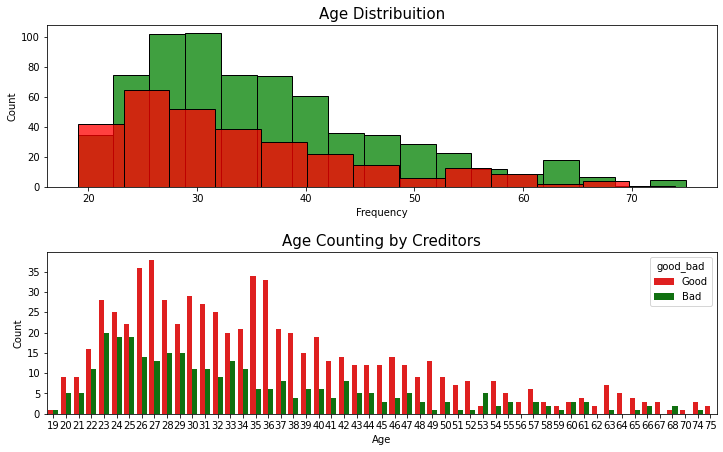

In [15]:
df_good = df_credit[df_credit["good_bad"] == 'Good']
df_bad = df_credit[df_credit["good_bad"] == 'Bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.histplot(df_good["Age"], ax=ax[0], color="g")
g1 = sns.histplot(df_bad["Age"], ax=ax[0], color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Frequency")


g2 = sns.countplot(x="Age",data=df_credit,
              palette=['r',"g"],  
              hue = "good_bad")
g2.set_title("Age Counting by Creditors", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
plt.show()

### UNIVARIATE ANALYSIS

<Axes: xlabel='Age', ylabel='Count'>

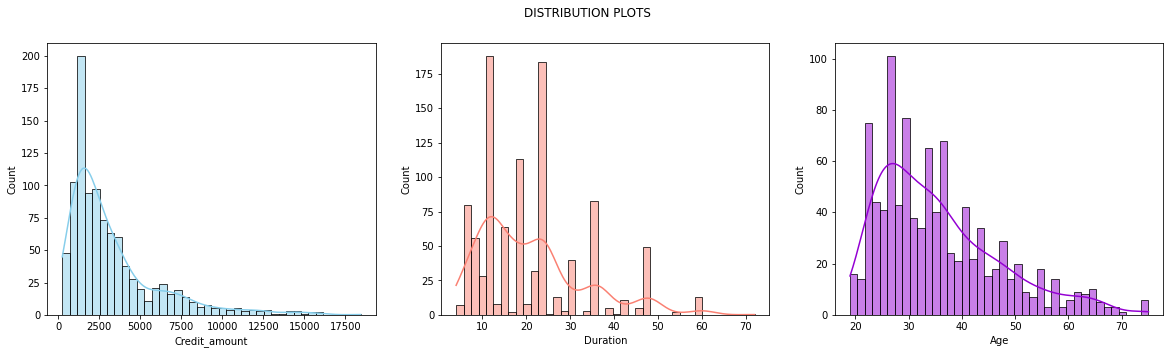

In [16]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS')
sns.histplot(df_credit['Credit_amount'], bins=40, ax=ax[0], kde=True, color='skyblue')
sns.histplot(df_credit['Duration'], bins=40, ax=ax[1], kde=True, color='salmon')
sns.histplot(df_credit['Age'], bins=40, ax=ax[2], kde=True, color='darkviolet')

### INSIGHTS
---
* Most of the credit cards have an amount of 1500 - 4000
* The Credit amount is positively skewed, So the samples are dispersed

In [17]:
#Show basic stats
df_credit[['Age', 'Duration', 'Credit_amount']].describe()

Age     Duration  Credit_amount
count  1000.000000  1000.000000    1000.000000
mean     35.546000    20.903000    3271.258000
std      11.375469    12.058814    2822.736876
min      19.000000     4.000000     250.000000
25%      27.000000    12.000000    1365.500000
50%      33.000000    18.000000    2319.500000
75%      42.000000    24.000000    3972.250000
max      75.000000    72.000000   18424.000000

### BIVARIATE ANALYSIS

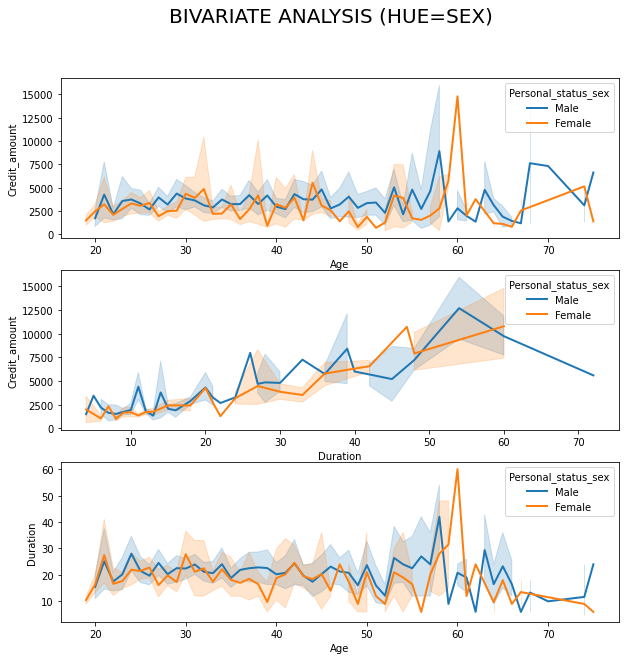

In [18]:
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A91'],'Male') #A91 : male   : divorced/separated
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A94'],'Male') #A94 : male   : married/widowed
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A93'],'Male') #A93 : male   : single
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A92'],'Female') #A92 : female : divorced/separated/married
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A95'],'Female') #A95 : female : single
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=SEX)', fontsize=20)

sns.lineplot(data=df_credit, x='Age', y='Credit_amount', hue='Personal_status_sex', lw=2, ax=ax[0]);
sns.lineplot(data=df_credit, x='Duration', y='Credit_amount', hue='Personal_status_sex', lw=2, ax=ax[1]);
sns.lineplot(data=df_credit, x='Age', y='Duration', hue='Personal_status_sex', lw=2, ax=ax[2]);


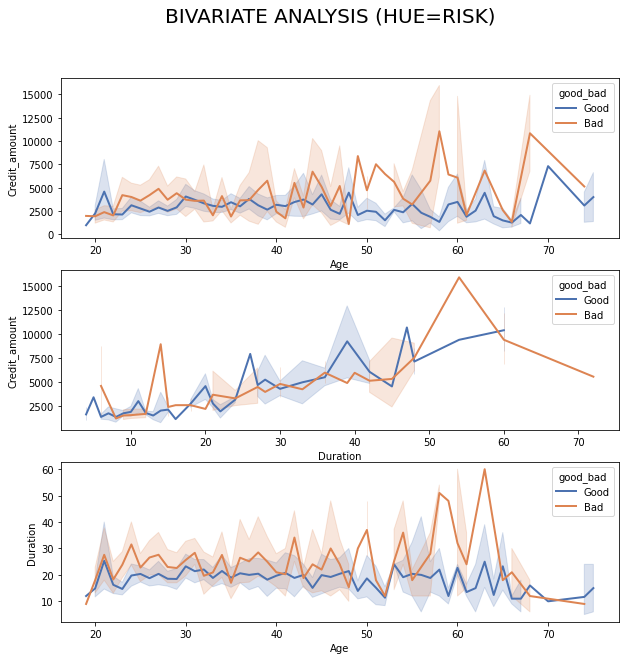

In [19]:
ig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=RISK)', fontsize=20)

sns.lineplot(data=df_credit, x='Age', y='Credit_amount', hue='good_bad', lw=2, ax=ax[0], palette='deep');
sns.lineplot(data=df_credit, x='Duration', y='Credit_amount', hue='good_bad', lw=2, ax=ax[1], palette='deep');
sns.lineplot(data=df_credit, x='Age', y='Duration', hue='good_bad', lw=2, ax=ax[2], palette='deep');

### INSIGHTS
---
* There is a linear relationship between Duration and Creadit Amount, Which makes sense because usually, people take bigger credits for longer periods. 
* The trend Between Age and Credit amount is not clear.

### PAIRPLOT TO VISUALIZE FEATURES WITH LINEAR RELATIONSHIP

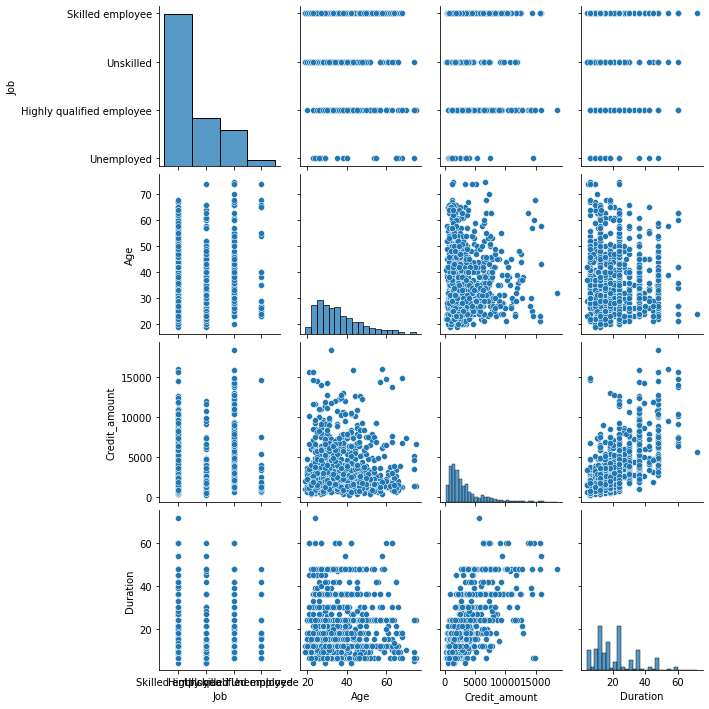

In [20]:
df_credit['Job'] = df_credit['Job'].replace(['A171'],'Unemployed')
df_credit['Job'] = df_credit['Job'].replace(['A172'],'Unskilled')
df_credit['Job'] = df_credit['Job'].replace(['A173'],'Skilled employee')
df_credit['Job'] = df_credit['Job'].replace(['A174'],'Highly qualified employee')
sns.pairplot(df_credit, vars=['Job','Age','Credit_amount','Duration']);

# A171 : unemployed/ unskilled  - non-resident
# A172 : unskilled - resident
# A173 : skilled employee / official
# A174 : management/ self-employed/highly qualified employee/ officer



######################################################
#Use only credit_amount relationships 


In [21]:
fig = px.scatter(df_credit, 
                 x='Credit_amount', 
                 y='Duration', 
                 color='good_bad', 
                 opacity=0.8, 
                 hover_data=['Personal_status_sex','Age'], 
                 title='Duration vs. Credit amount')
fig.update_traces(marker_size=5)
fig.show()

#### PROVARE A FARE L'EFFETTO DI AGGIUNGERE RUMORE PER MARCARE ANCORA DI PIU' L'ANDAMENTO 
### TRy to add Jitter

### **We tried to emphasize this correlation by adding noise according to the jitter technique**

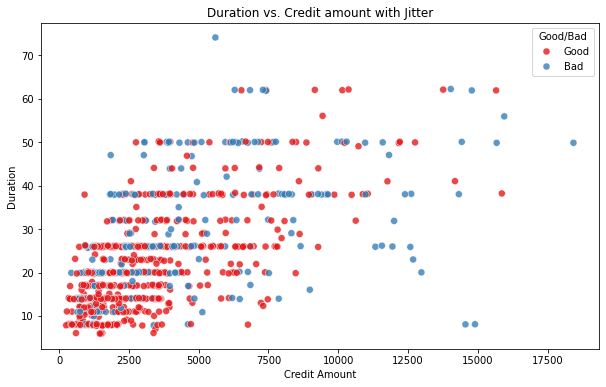

In [22]:
def jitter(values, j):
    return values + np.random.normal(j, 0.1, values.shape)

# Assuming df_credit is your DataFrame containing the data

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=jitter(df_credit['Credit_amount'], 2), y=jitter(df_credit['Duration'], 2), hue=df_credit['good_bad'], palette='Set1', alpha=0.8, 
                size=df_credit['good_bad'], sizes=[50, 50])

# Additional customization
plt.title('Duration vs. Credit amount with Jitter')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.legend(title='Good/Bad', loc='upper right')

plt.show()




### **We have inserted an effect to accentuate the points of greatest density**

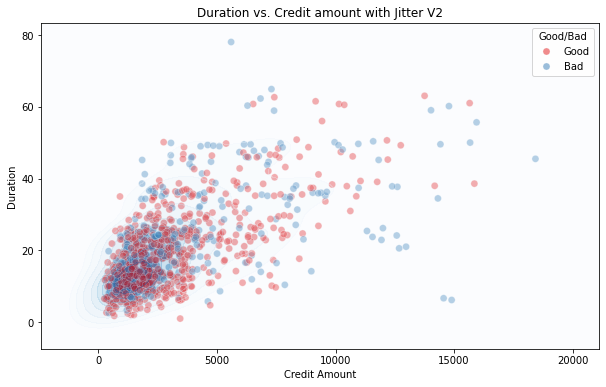

In [23]:
def jitter(values, j):
    return values + np.random.normal(0, j, values.shape)

# Assuming df_credit is your DataFrame containing the data

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=jitter(df_credit['Credit_amount'], 2), y=jitter(df_credit['Duration'], 2), hue=df_credit['good_bad'], palette='Set1', alpha=0.5, 
                size=df_credit['good_bad'], sizes=[50, 50])

# Calculate point density
sns.kdeplot(data=df_credit, x='Credit_amount', y='Duration', cmap="Blues", fill=True, thresh=False, alpha=0.3)

# Additional customization
plt.title('Duration vs. Credit amount with Jitter V2')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.legend(title='Good/Bad', loc='upper right')

plt.show()



### Credit Amount
---
The next 4 plots are a different visualizzation of the Credit_Amount visualization

#### Credit_Amount - Count

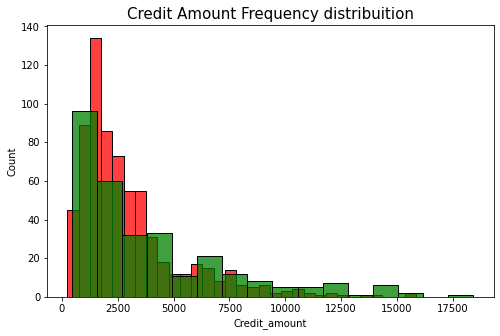

In [24]:
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.histplot(df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"], color='r')
g = sns.histplot(df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"], color='g')
g.set_title("Credit Amount Frequency distribuition", fontsize=15)
plt.show()

##### I woul considera a gaussian distribution for plotting Credit_Amount and Count

#### Credit_Amount - Job

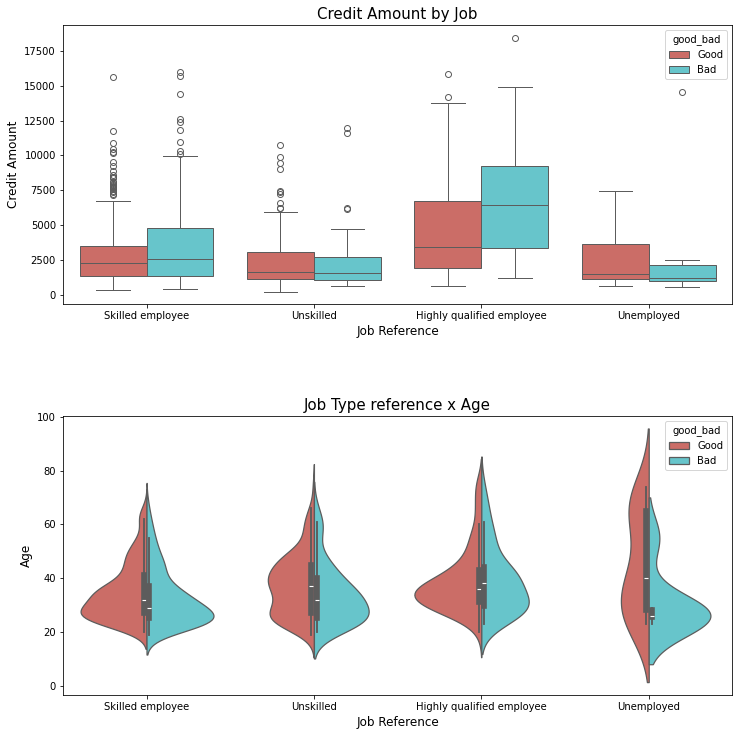

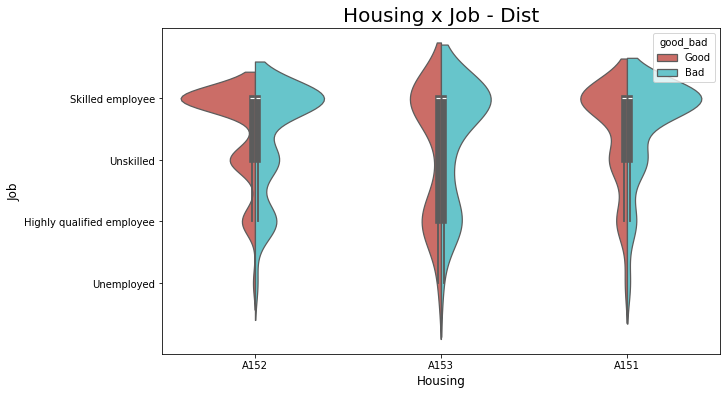

In [25]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

g1 = sns.boxplot(x="Job", y="Credit_amount", data=df_credit, 
            palette="hls", ax=ax[0], hue="good_bad")
g1.set_title("Credit Amount by Job", fontsize=15)
g1.set_xlabel("Job Reference", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)

g2 = sns.violinplot(x="Job", y="Age", data=df_credit, ax=ax[1],  
               hue="good_bad", split=True, palette="hls")
g2.set_title("Job Type reference x Age", fontsize=15)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

###############################################################################################################################################
#Credit Amount by Job (da tenere solo per la relazione perchè è molto chiara)
#Job type reference x Age (da togliere)

trace0 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["Job"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)

trace1 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Job"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

######################################################################################################################################################
# Da utilizzare per fare eventuali considerazioni numeriche, anche se non ne sono troppo sicuro

plt.figure(figsize = (10,6))

g = sns.violinplot(x="Housing",y="Job",data=df_credit,
                   hue="good_bad", palette="hls",split=True)
g.set_xlabel("Housing", fontsize=12)
g.set_ylabel("Job", fontsize=12)
g.set_title("Housing x Job - Dist", fontsize=20)

plt.show()

##################################################################################################################################################


#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Job"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Job"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

<h2>Creating a categorical variable to handle with the Age variable </h2>

In [26]:
#Let's look the Credit Amount column
interval = (19, 25, 35, 50, 70)

cats = ['Senior (35-50)', 'Adult (25-35)', 'Young (19-25)', 'Student (0-19)']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats) #age_categories


df_good = df_credit[df_credit["good_bad"] == 'Good']
df_bad = df_credit[df_credit["good_bad"] == 'Bad']

###################################################################################################################


trace0 = go.Box(
    y=df_good["Credit_amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit_amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (Express in US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

# Credit Amount - Housing

<h2>I will now Look the distribuition of Housing own and rent by Risk</h2>


In [27]:
df_credit['Housing'] = df_credit['Housing'].replace(['A151'],'rent')
df_credit['Housing'] = df_credit['Housing'].replace(['A152'],'own')
df_credit['Housing'] = df_credit['Housing'].replace(['A153'],'free')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

##################################################################################################################################################
# Maybe we can create a section in which we briefly examinate all the aspect, but in general i don't think this is useful





trace0 = go.Box(
    y=df_credit["Credit_amount"],
    x=df_credit["Housing"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_credit['Credit_amount'],
    x=df_credit['Housing'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (Express in US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Distribuition of Credit Amount by Housing'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

#### Credit Amount - Sex

In [28]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

#### Credit Amount - Foreign worker

In [29]:
df_credit['foreign_worker'] = df_credit['foreign_worker'].replace(['A201'],'foreign worker')
df_credit['foreign_worker'] = df_credit['foreign_worker'].replace(['A202'],'None foreign worker')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Foreign worker comparison', 'Credit Amount by foreign worker'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Foreign worker Distribuition', boxmode='group')
py.iplot(fig, filename='Foreign_worker-subplot')

In [30]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Status_account           1000 non-null   object  
 1   Duration                 1000 non-null   int64   
 2   Credit_history           1000 non-null   object  
 3   Purpose                  1000 non-null   object  
 4   Credit_amount            1000 non-null   int64   
 5   Savings_account_bonds    1000 non-null   object  
 6   Employment_since         1000 non-null   object  
 7   Install_rate             1000 non-null   int64   
 8   Personal_status_sex      1000 non-null   object  
 9   debtors_guarantors       1000 non-null   object  
 10  Present_residence_since  1000 non-null   int64   
 11  Property                 1000 non-null   object  
 12  Age                      1000 non-null   int64   
 13  Other_install_plans      1000 non-null   object  
 14  Housing  

### Credit Amount - Saving Accounts

Description of Distribuition Saving accounts by Risk:  
good_bad               Bad  Good
Savings_account_bonds           
Bad                    217   386
Excellent                6    42
Good                    11    52
Middle                  34    69
No saving account       32   151


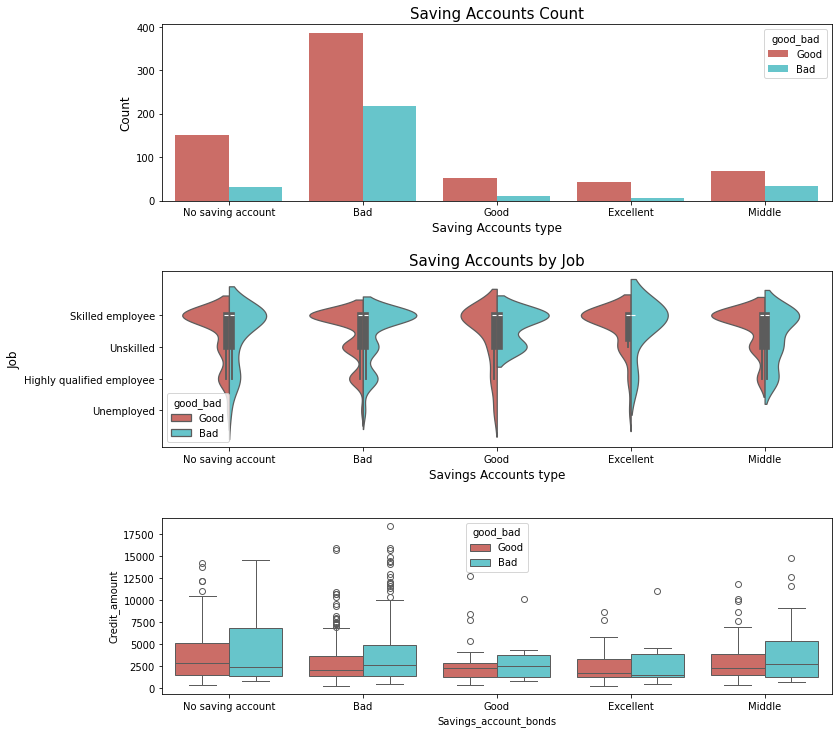

In [31]:
#Attibute 6:  (qualitative)
#	      Savings account/bonds
#	      A61 :          ... <  100 DM Bad
#	      A62 :   100 <= ... <  500 DM Middle
#	      A63 :   500 <= ... < 1000 DM Good
#	      A64 :          .. >= 1000 DM Excellent
#              A65 :   unknown/ no savings account
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A61'],'Bad')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A62'],'Middle')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A63'],'Good')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A64'],'Excellent')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A65'],'No saving account')

count_good = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')


######################################################################################################################################################
#Also here, i would consider "Credit Amount by Savings Acc" but the others i don't think they're interesting

print("Description of Distribuition Saving accounts by Risk:  ")
print(pd.crosstab(df_credit["Savings_account_bonds"],df_credit.good_bad))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Savings_account_bonds", data=df_credit, palette="hls", 
              ax=ax[0],hue="good_bad")
g.set_title("Saving Accounts Count", fontsize=15)
g.set_xlabel("Saving Accounts type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Savings_account_bonds", y="Job", data=df_credit, palette="hls", 
               hue = "good_bad", ax=ax[1],split=True)
g1.set_title("Saving Accounts by Job", fontsize=15)
g1.set_xlabel("Savings Accounts type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Savings_account_bonds", y="Credit_amount", data=df_credit, ax=ax[2],
            hue = "good_bad",palette="hls")
g2.set_title("Saving Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Savings Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


########################################################################
# The last image is exactly the same as the last previouse one "Credit Account by saving account", so as before
# Quella con cui si può interagire (che restituire min, max, mean, ecc...) la possiamo usare per fare delle considerazioni nella relazione.
# Mentre quella quì in basso la possiamo usare per visualizzare meglio gli outliers



### Credit Amount - Status Accounts

Description of Distribuition Status accounts by Risk:  
good_bad        Bad  Good
Status_account           
In Debt         135   139
Normal          105   164
Rich             14    49
Uknown           46   348


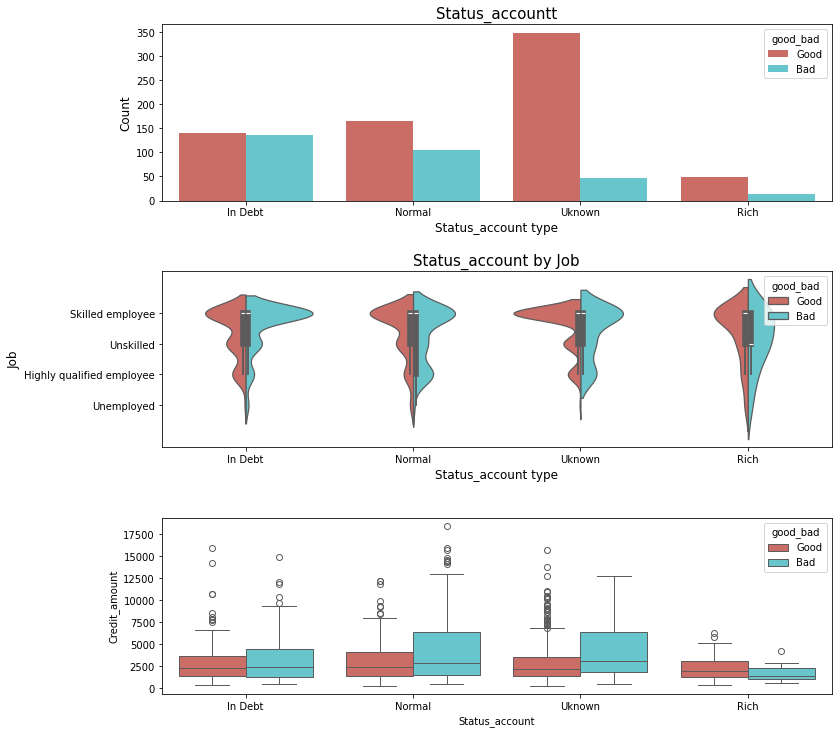

In [32]:
#Attribute 1:  (qualitative)
#	       Status of existing checking account
#               A11 :      ... <    0 DM
#	       A12 : 0 <= ... <  200 DM
#	       A13 :      ... >= 200 DM /
#		     salary assignments for at least 1 year
#               A14 : no checking account

df_credit['Status_account'] = df_credit['Status_account'].replace(['A11'],'In Debt')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A12'],'Normal')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A13'],'Rich')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A14'],'Uknown')


count_good = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Status_account','Credit Amount by Status_account', 
                                          'Age by Status_account'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Status_account Exploration', boxmode='group')

py.iplot(fig, filename='combined-statusAccount')

print("Description of Distribuition Status accounts by Risk:  ")
print(pd.crosstab(df_credit["Status_account"],df_credit.good_bad))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Status_account", data=df_credit, palette="hls", 
              ax=ax[0],hue="good_bad")
g.set_title("Status_accountt", fontsize=15)
g.set_xlabel("Status_account type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Status_account", y="Job", data=df_credit, palette="hls", 
               hue = "good_bad", ax=ax[1],split=True)
g1.set_title("Status_account by Job", fontsize=15)
g1.set_xlabel("Status_account type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Status_account", y="Credit_amount", data=df_credit, ax=ax[2],
            hue = "good_bad",palette="hls")
g2.set_title("Status Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Status Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


### Credit_Amount - Purpose

Values describe: 
good_bad             Bad  Good
Purpose                       
Business              34    63
Domestic appliances    4     8
Education             22    28
Furniture/equipment   58   123
New Car               89   145
Others                 5     7
Radio/television      62   218
Repairs                8    14
Retraining             1     8
Used Car              17    86


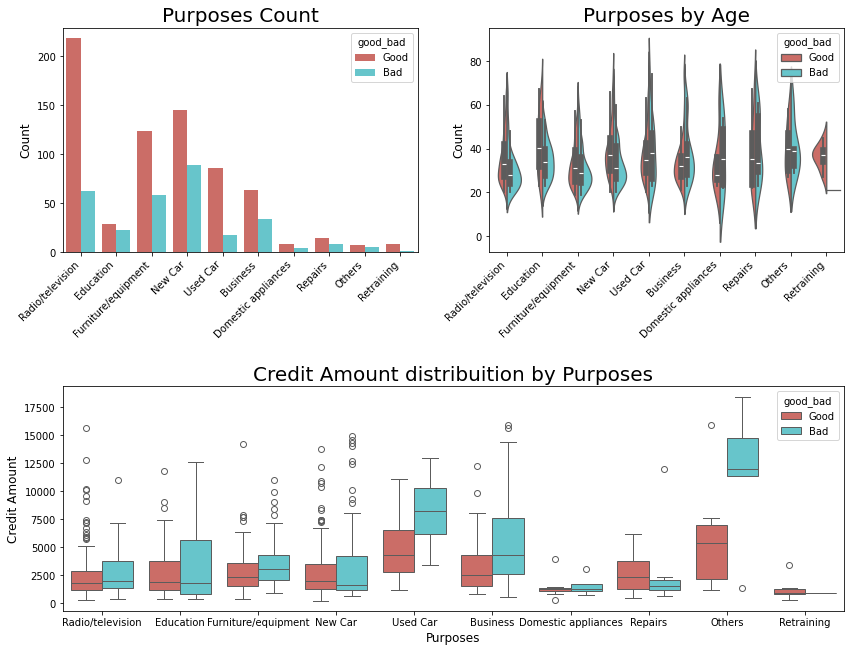

In [33]:
## Gianluca : Alberto vedi se toglierlo 
## Alberto : NO!!
df_credit['Purpose'] = df_credit['Purpose'].replace(['A40'],'New Car')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A41'],'Used Car')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A42'],'Furniture/equipment')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A43'],'Radio/television')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A44'],'Domestic appliances')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A45'],'Repairs')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A46'],'Education')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A47'],'Vacation')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A48'],'Retraining')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A49'],'Business')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A410'],'Others')
print("Values describe: ")
print(pd.crosstab(df_credit.Purpose, df_credit.good_bad))

plt.figure(figsize = (14,12))


plt.subplot(221)
g = sns.countplot(x="Purpose", data=df_credit, 
              palette="hls", hue = "good_bad")
g.set_xticks(g.get_xticks())
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df_credit, 
                    palette="hls", hue = "good_bad",split=True)
g1.set_xticks(g1.get_xticks())
g1.set_xticklabels(g1.get_xticklabels(),rotation=45, ha="right")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit_amount", data=df_credit, 
               palette="hls", hue = "good_bad")
g2.set_xticks(g2.get_xticks())
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

### Credit_Amount - Duration

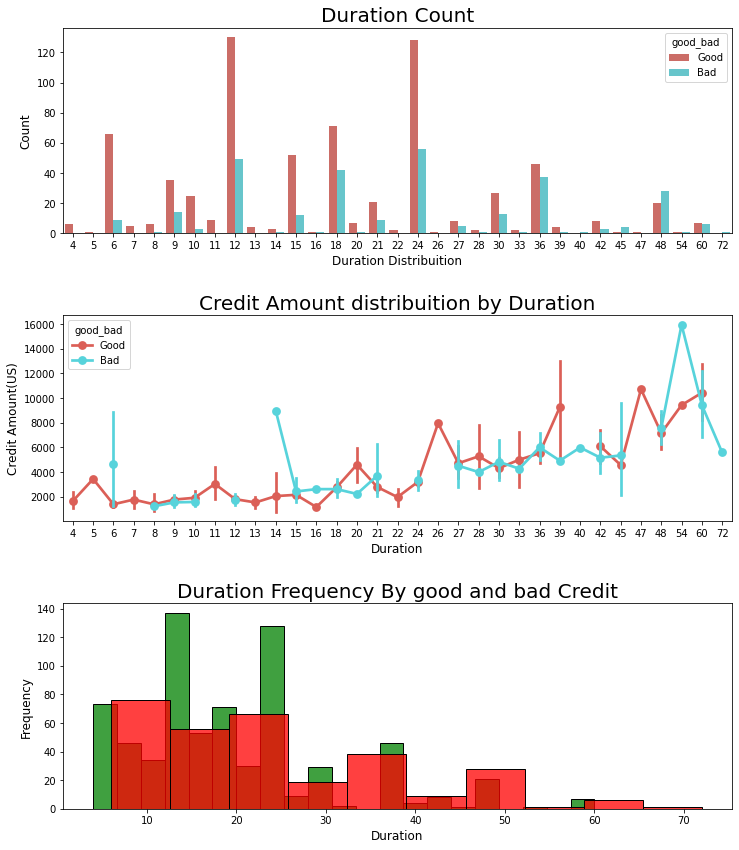

In [34]:
plt.figure(figsize = (12,14))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df_credit, 
              palette="hls",  hue = "good_bad")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit_amount",data=df_credit,
                   hue="good_bad", palette="hls")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.histplot(df_good["Duration"], color='g')
g2 = sns.histplot(df_bad["Duration"], color='r')
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency By good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()

<h2> Checking/Status Account variable </h2>

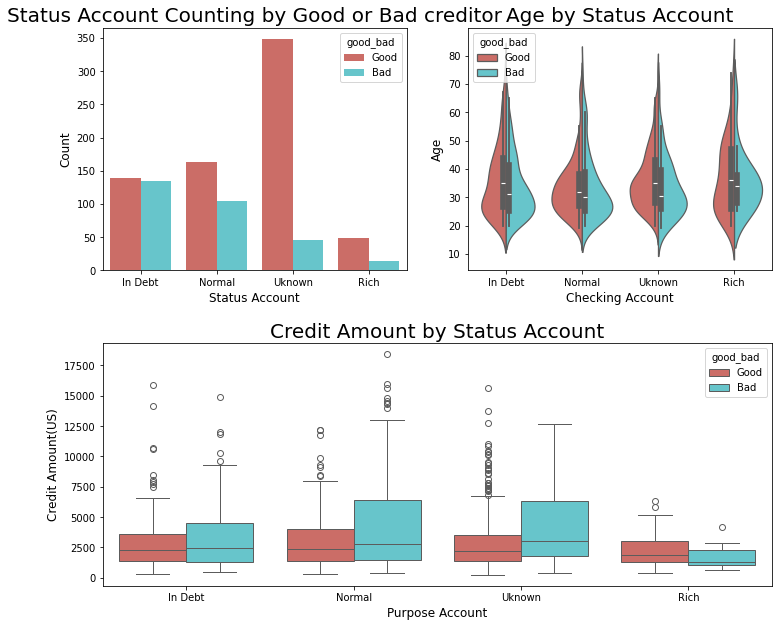

In [35]:
df_credit['Status_account'] = df_credit['Status_account'].replace(['A11'],'In Debt')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A12'],'Moderate')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A13'],'Rich')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A14'],'No checking')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Status accounts Distribuition',
    xaxis=dict(title='Status accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'Age-ba', validate = False)

trace0 = go.Box(
    y=df_credit[df_credit["good_bad"] == 'Good']["Credit_amount"],
    x=df_credit[df_credit["good_bad"] == 'Good']["Status_account"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_credit[df_credit["good_bad"] == 'Bad']['Credit_amount'],
    x=df_credit[df_credit["good_bad"] == 'Bad']['Status_account'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Status distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

##################################################
plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Status_account", data=df_credit, 
              palette="hls", hue="good_bad")
g.set_xlabel("Status Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Status Account Counting by Good or Bad creditor", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Status_account", y="Age", data=df_credit, palette="hls", hue = "good_bad",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Status Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Status_account",y="Credit_amount", data=df_credit,hue='good_bad',palette="hls")
g2.set_xlabel("Purpose Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Status Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()

In [36]:
print(pd.crosstab(df_credit.Personal_status_sex, df_credit.Job))

Job                  Highly qualified employee  Skilled employee  Unemployed  \
Personal_status_sex                                                            
Female                                      37               197          12   
Male                                       111               433          10   

Job                  Unskilled  
Personal_status_sex             
Female                      64  
Male                       136  


In [37]:
print(pd.crosstab(df_credit["Status_account"],df_credit.Personal_status_sex))

Personal_status_sex  Female  Male
Status_account                   
In Debt                  88   186
Normal                   86   183
Rich                     20    43
Uknown                  116   278


In [38]:
print(pd.crosstab(df_credit["Purpose"],df_credit.Personal_status_sex))

Personal_status_sex  Female  Male
Purpose                          
Business                 19    78
Domestic appliances       6     6
Education                21    29
Furniture/equipment      74   107
New Car                  70   164
Others                    3     9
Radio/television         85   195
Repairs                   5    17
Retraining                3     6
Used Car                 24    79


## **Remember the result of data preprocessing is df_normalized**

# 2 Unsupervised exploration and clustering #

### 2.1 Dimensionality reduction for data visualization ###

<function matplotlib.pyplot.show(close=None, block=None)>

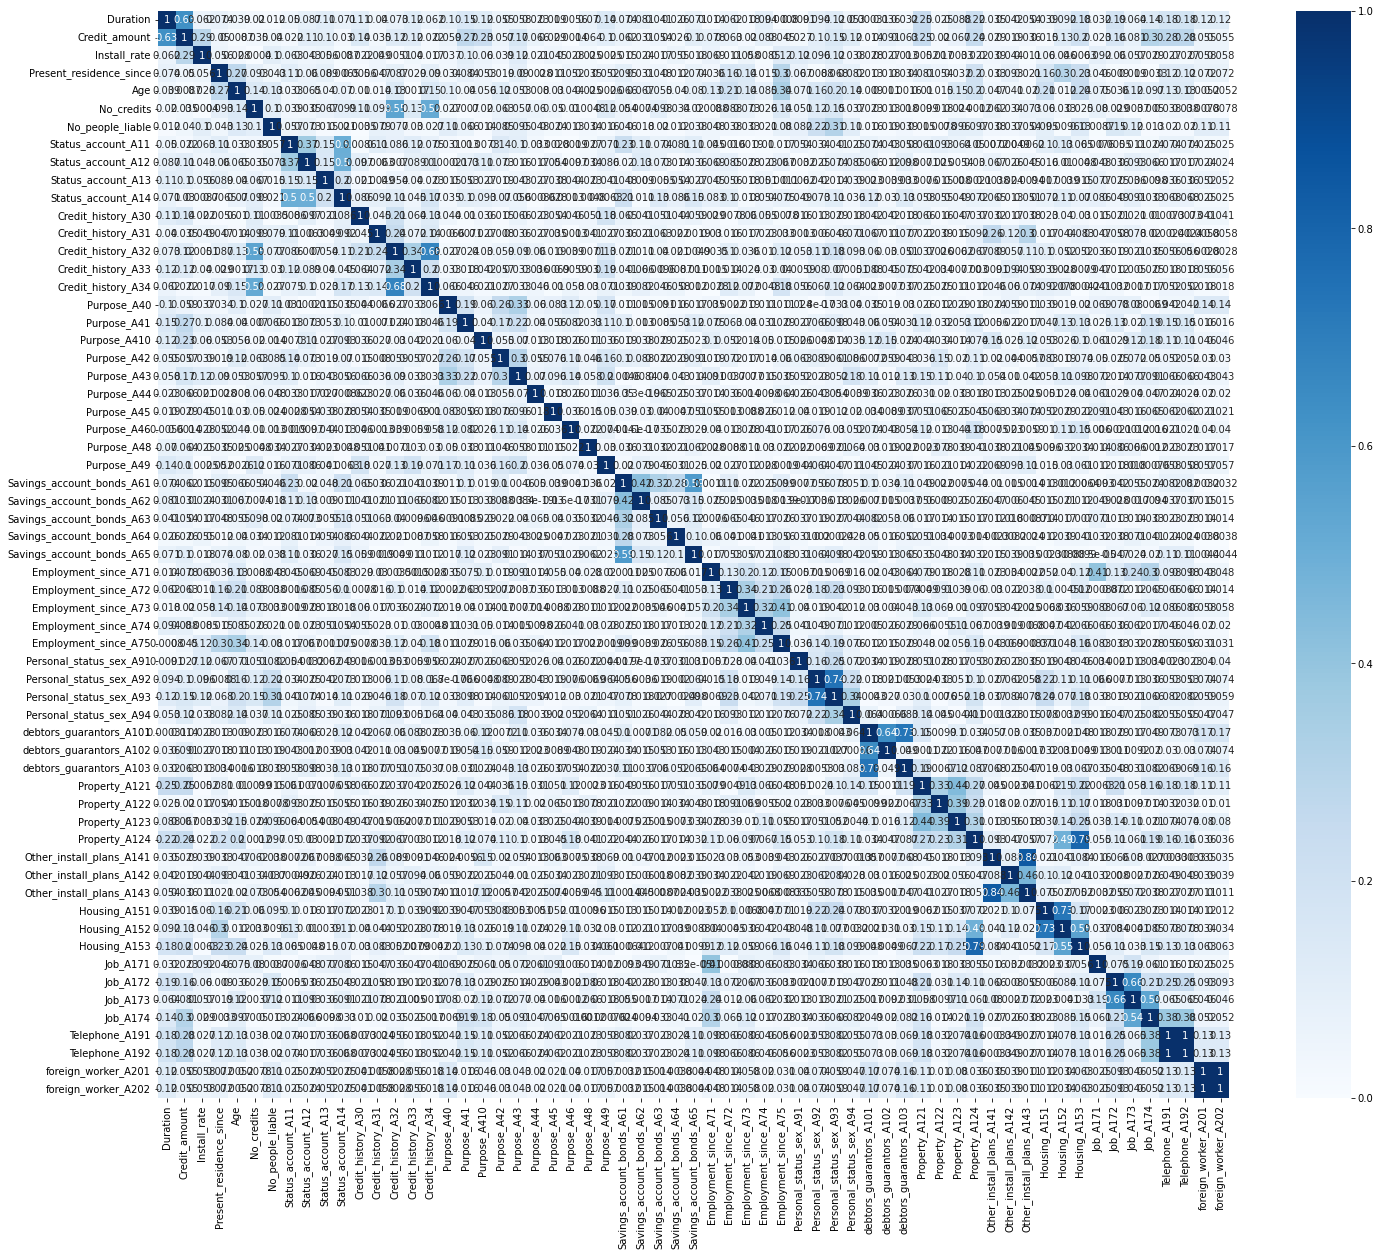

In [39]:
#### Apply dimensionality reduction techniques: t-Distributed Stochastic Neighbor Embedding (t-SNE)
#### and Principal Component Analysis (PCA) to reduce and visualize the data.

#### I compute the correlation between the features to see if there are any correlated features
correlation_analysis = X.corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

##### 2.1.1 PCA

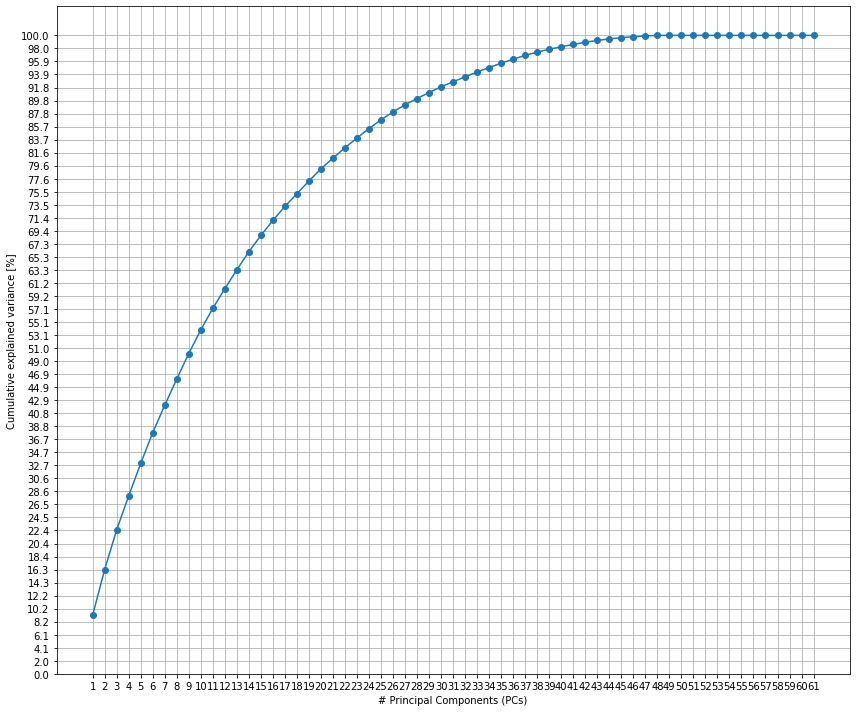

0 : 9.157925436517077
1 : 16.323037261819735
2 : 22.54426291088664
3 : 27.862541556699444
4 : 32.94708626906171
5 : 37.76963173274768
6 : 42.05501688785597
7 : 46.163091269312616
8 : 50.16518130979779
9 : 53.85589579703329
10 : 57.242230796197546
11 : 60.319868016777846
12 : 63.271479245556336
13 : 66.1043558062183
14 : 68.66213761122967
15 : 71.00781886609332
16 : 73.20527782094273
17 : 75.20106141435025
18 : 77.18927903020867
19 : 79.09519774604496
20 : 80.77688582389302
21 : 82.39445953608762
22 : 83.92281784646674
23 : 85.41446434379544
24 : 86.76234104335322
25 : 88.01573238041208
26 : 89.13042121930854
27 : 90.11254457673417
28 : 91.04547946373943
29 : 91.95184123160233
30 : 92.7352194251198
31 : 93.51122957381116
32 : 94.26563197582533
33 : 94.97097371924619
34 : 95.64966133527369
35 : 96.28016903773513
36 : 96.86731042603873
37 : 97.38569133667396
38 : 97.82611836609343
39 : 98.22865557231401
40 : 98.58359475092962
41 : 98.9300912055982
42 : 99.21209209891762
43 : 99.4434284852

In [40]:
#### PCA to check the variances

pca = PCA(random_state=15)
pca.fit(X)

#### Here i compute the variability of the dataset, while the varaible number keeps increasing, 
#### until reaching all the number
explained_variance = pca.explained_variance_ratio_

#### This allows to represent the sum for each step (remember 61 features)
cum_exp_var = np.cumsum(explained_variance)

#### Representing it in percentage
perc_cum_exp_var = cum_exp_var * 100

#### Make the plot of cumulative explained variance w.r.t. number of components
plt.figure(figsize=(12, 10))
plt.plot(perc_cum_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(61)], [i for i in range(1,62)])
plt.yticks(np.linspace(0,100, 50))
plt.grid()
plt.tight_layout()
plt.show()

for i in range (len(perc_cum_exp_var)):
    print(i, ":", perc_cum_exp_var[i])

##### SMOTE for oversampling

In [41]:
sm = SMOTE(random_state=60)
X_res, y_res = sm.fit_resample(X, y)

In [42]:
#### I choose 47 components because I'll be able to describe 100% of the dataset
pca = PCA(n_components = 30)
pca.fit(X_res)

X_PCA = pca.transform(X_res)
X_test_PCA = pca.transform(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

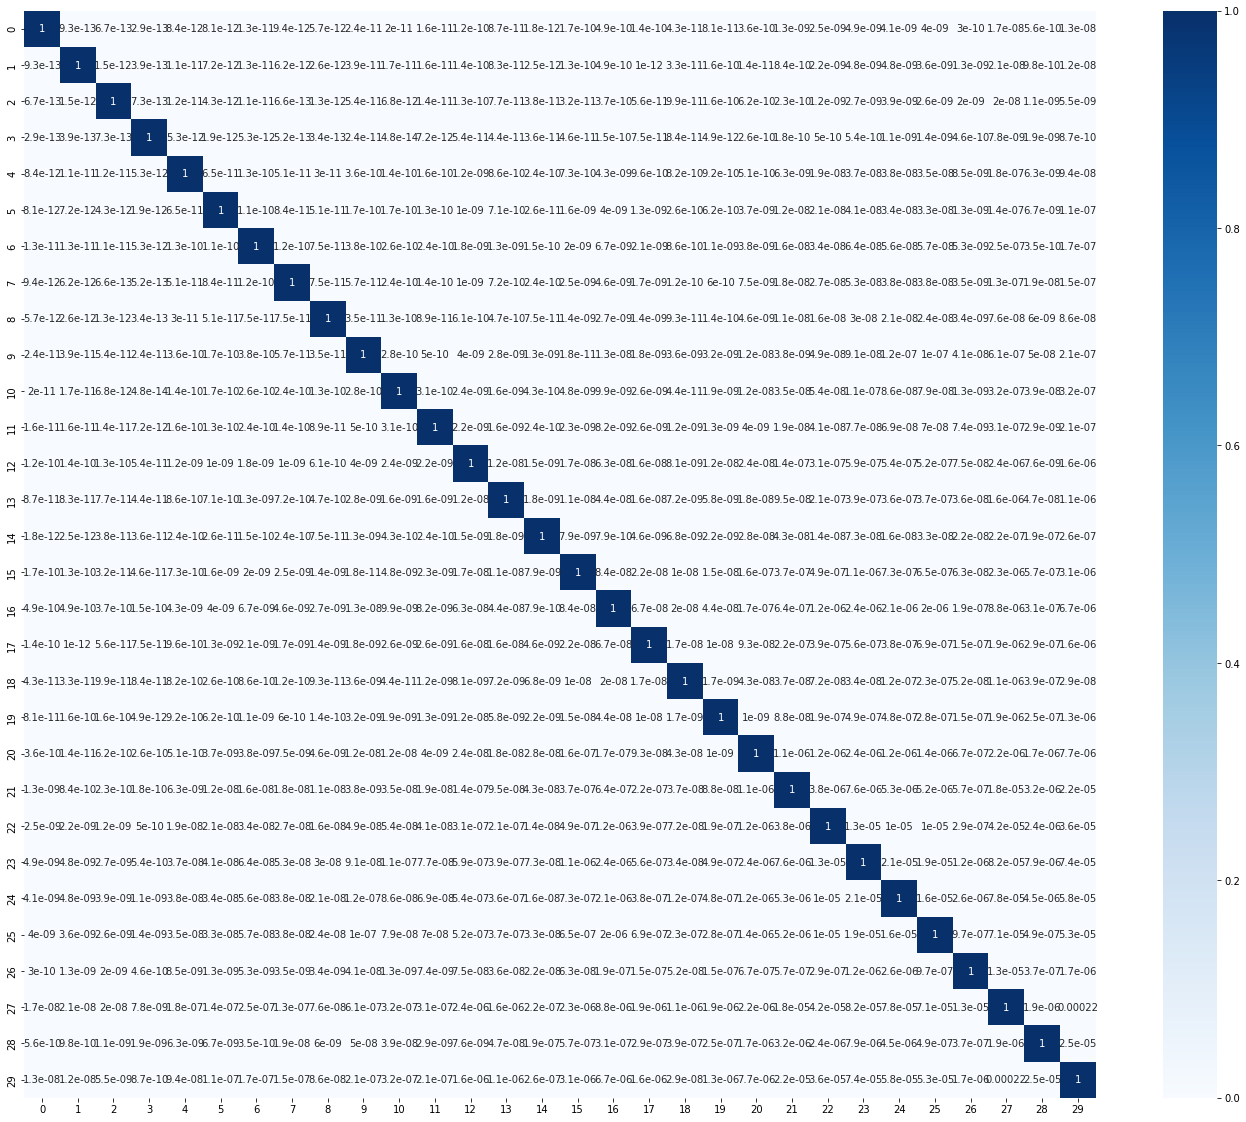

In [43]:
####Compute the correlation matrix after PCA
correlation_analysis = pd.DataFrame(X_PCA).corr().abs()
plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

#### No more correlation between different features after PCA
#### X is the transformed training dataset using PCA, it will have 45 features, 
#### with a total variance of the dataset of 99,78%

##### 2.1.2 T-sne

In [44]:
#### I Apply t-SNE for dimensionality reduction
perplexities = [5, 10, 20, 30, 50]
learning_rate = np.linspace(10, 1000, 5)

plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities, 1):
    for lr in learning_rate:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate = lr)
        X_tsne = tsne.fit_transform(X[X_encoded.columns])
        if (perplexity == 5 and lr == 10):
            transformed_df_t_sne = pd.DataFrame(X_tsne, columns = ['C1', 'C2'])

        # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        # plt.title(f't-SNE Visualization (Perplexity={perplexity}, Learning Rate={lr})')
        # plt.show()

transformed_df_t_sne

C1         C2
0     6.205675   0.818944
1   -54.767479 -11.684712
2    57.146175  -1.132252
3   -11.682610  45.248863
4    56.019215  33.122780
..         ...        ...
795  33.794113  27.352081
796  65.468628  20.466789
797 -23.973745  -7.632000
798  42.325092   2.476051
799  53.134464  10.137154

[800 rows x 2 columns]

<Figure size 1080x720 with 0 Axes>

#     3 Supervised Data Analysis

### 3.1 Classifier Selection
We choose from various classifiers, notably:
- Decision Tree classifier
- Gaussian Naive Bayes classifier
- K-Nearest Neighbors classifier
- Support Vector Machines classifier
- Logistic regressor
- Neural Networks 

### 3.2 Cross-Validation

#### Here we consider non NN classifiers

##### Without PCA 

In [45]:
warnings.filterwarnings('ignore')

best = 0
DT_parameters = {"criterion":['gini', 'entropy', 'log_loss'], 'max_depth':[None, 4, 6, 8, 10, 12, 14], 'min_samples_split':[2, 3, 4, 5, 6, 7, 8]}
GNB_parameters = {"var_smoothing": (np.logspace(-9,0,10))}
KNN_parameters = {"n_neighbors": range(1,31), "weights": ['uniform','distance'], "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
SVM_parameters = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "C": [100, 10, 1.0, 0.1, 0.001]}
LR_parameters = {"penalty": ['l1', 'l2', 'elasticnet', None], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C": [100, 10, 1.0, 0.1, 0.01], "max_iter": [200]}
classifiers = [{"classifier": DecisionTreeClassifier, "parameters": DT_parameters}, {"classifier": GaussianNB, "parameters": GNB_parameters},
               {"classifier": KNeighborsClassifier, "parameters": KNN_parameters}, {"classifier": svm.SVC, "parameters": SVM_parameters}, 
               {"classifier": LogisticRegression, "parameters": LR_parameters}]
#We use 'X_res' as dataset 
for classifier in classifiers:
    clf = GridSearchCV(classifier["classifier"](), classifier["parameters"], cv = StratifiedKFold(n_splits=20), scoring = 'accuracy', n_jobs=10)
    clf.fit(X_res, y_res)
    if (clf.best_score_ > best):
        best = clf.best_score_
        best_clf = clf
        best_clf_param = list(classifier["parameters"].keys())
        best_clf_name = classifier["classifier"]
        best_clf_score = clf.best_score_
    print("Best Score for " + str(classifier["classifier"]()).replace("()","") + ":", clf.best_score_,"\n")
print("\nBest Classifier: " + str(best_clf_name()).replace("()",""))
print("Best Score: ",best_clf_score)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

Best Score for DecisionTreeClassifier: 0.7919642857142857 

Best Score for GaussianNB: 0.7526785714285713 

Best Score for KNeighborsClassifier: 0.8419642857142857 



['kernel', 'C']


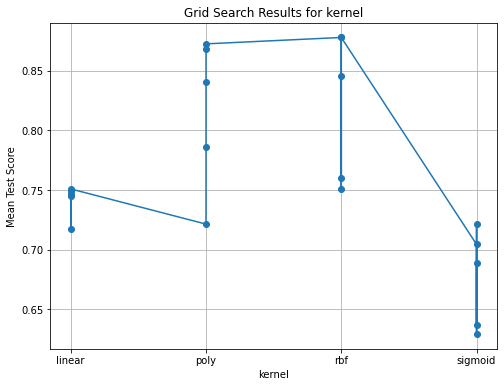

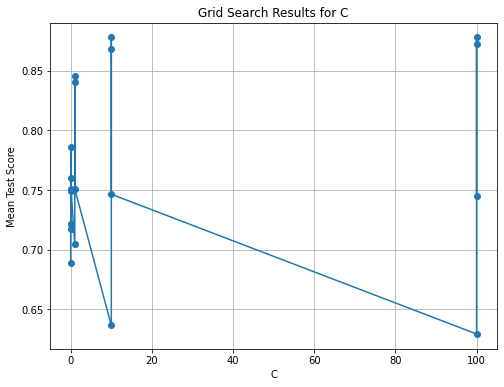

In [ ]:
def plot_grid_search(cv_results, param_name, scoring=None):
    if scoring is None:
        scoring = list(cv_results['mean_test_score'])[0]
        
    # Extract the mean test scores and the parameter values
    mean_test_scores = cv_results['mean_test_score']
    param_values = cv_results['param_' + param_name].data

    # Sort the parameter values and corresponding test scores
    sorted_indices = np.argsort(param_values)
    sorted_param_values = np.array(param_values)[sorted_indices]
    sorted_mean_test_scores = np.array(mean_test_scores)[sorted_indices]

    plt.figure(figsize=(8, 6))
    plt.plot(sorted_param_values, sorted_mean_test_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title(f'Grid Search Results for {param_name}')
    plt.grid(True)
    plt.show()

print(best_clf_param)
for i in range(len(best_clf_param)):
    plot_grid_search(best_clf.cv_results_, best_clf_param[i])


##### With PCA 

In [ ]:
best = 0
DT_parameters = {"criterion":['gini', 'entropy', 'log_loss'], 'max_depth':[None, 4, 6, 8, 10, 12, 14], 'min_samples_split':[2, 3, 4, 5, 6, 7, 8]}
GNB_parameters = {"var_smoothing": (np.logspace(-9,0,10))}
KNN_parameters = {"n_neighbors": range(1,31), "weights": ['uniform','distance'], "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
SVM_parameters = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "C": [100, 10, 1.0, 0.1, 0.001]}
LR_parameters = {"penalty": ['l1', 'l2', 'elasticnet', None], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C": [100, 10, 1.0, 0.1, 0.01], "max_iter": [200]}
classifiers = [{"classifier": DecisionTreeClassifier, "parameters": DT_parameters}, {"classifier": GaussianNB, "parameters": GNB_parameters},
               {"classifier": KNeighborsClassifier, "parameters": KNN_parameters}, {"classifier": svm.SVC, "parameters": SVM_parameters}, 
               {"classifier": LogisticRegression, "parameters": LR_parameters}]

#With PCA, we can clearly see that there's no much difference
for classifier in classifiers:
    clf = GridSearchCV(classifier["classifier"](), classifier["parameters"], cv = StratifiedKFold(n_splits=20), scoring = 'accuracy', n_jobs=10)
    clf.fit(X_PCA, y_res)
    if (clf.best_score_ > best):
        best = clf.best_score_
        best_clf = clf
        best_clf_param = list(classifier["parameters"].keys())
        best_clf_name = classifier["classifier"]
        best_clf_score = clf.best_score_
    print("Best Score for " + str(classifier["classifier"]()).replace("()","") + ":", clf.best_score_,"\n")

print("\nBest Classifier: " + str(best_clf_name()).replace("()",""))
print("Best Score: ",best_clf_score)

Best Score for DecisionTreeClassifier: 0.767857142857143 

Best Score for GaussianNB: 0.7133928571428572 

Best Score for KNeighborsClassifier: 0.8544642857142858 

Best Score for SVC: 0.8803571428571427 



/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: U

Best Score for LogisticRegression: 0.7401785714285715 


Best Classifier: SVC
Best Score:  0.8803571428571427


/home/enrico/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


['kernel', 'C']


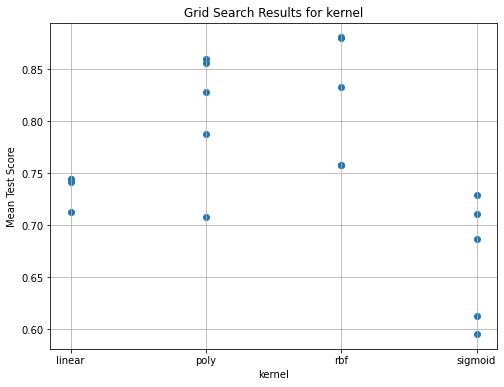

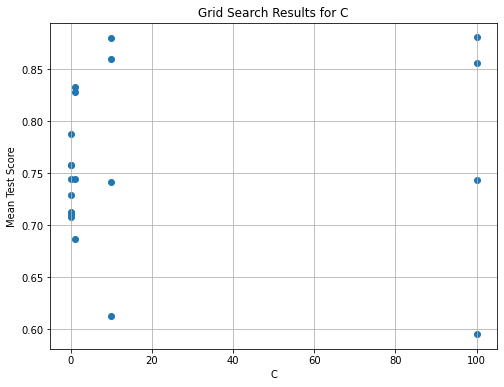

In [ ]:
def plot_grid_search(cv_results, param_name, scoring=None):
    if scoring is None:
        scoring = list(cv_results['mean_test_score'])[0]
        
    # Extract the mean test scores and the parameter values
    mean_test_scores = cv_results['mean_test_score']
    param_values = cv_results['param_' + param_name].data

    # Sort the parameter values and corresponding test scores
    sorted_indices = np.argsort(param_values)
    sorted_param_values = np.array(param_values)[sorted_indices]
    sorted_mean_test_scores = np.array(mean_test_scores)[sorted_indices]

    plt.figure(figsize=(8, 6))
    plt.scatter(sorted_param_values, sorted_mean_test_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title(f'Grid Search Results for {param_name}')
    plt.grid(True)
    plt.show()

print(best_clf_param)
for i in range(len(best_clf_param)):
    plot_grid_search(best_clf.cv_results_, best_clf_param[i])


#### Here we first split the dataset into train and validation sets

In [ ]:
print(f"X is: {len(X_res)}")
print(f"y is: {len(y_res)}")

X_train, X_val, y_train, y_val = train_test_split(
    X_PCA, y_res, 
    stratify=y_res, 
    train_size=0.75, 
    random_state=10
)

print(f"X_train is: {len(X_train)}")
print(f"y_train is: {len(y_train)}")
print(f"X_val is: {len(X_val)}")
print(f"y_val is: {len(y_val)}")
print(f"X_test is: {len(X_test)}")
print(f"y_test is: {len(y_test)}")

#### transform numpy array to pytorch tensor
X_train_t = torch.tensor(X_train, dtype=torch.float)
print(X_train_t.shape)
y_train_t = torch.tensor(np.ravel(y_train), dtype=torch.long)
print(y_train_t.shape)
X_val_t = torch.tensor(X_val, dtype=torch.float)
print(X_val_t.shape)
y_val_t = torch.tensor(np.ravel(y_val), dtype=torch.long)
print(y_val_t.shape)
X_test_t = torch.tensor(X_test_PCA, dtype=torch.float)
print(X_test_t.shape)
y_test_t = torch.tensor(np.ravel(y_test), dtype=torch.long)
print(y_test_t.shape)

X is: 1120
y is: 1120
X_train is: 840
y_train is: 840
X_val is: 280
y_val is: 280
X_test is: 200
y_test is: 200
torch.Size([840, 30])
torch.Size([840])
torch.Size([280, 30])
torch.Size([280])
torch.Size([200, 30])
torch.Size([200])


#### Definition of Neural Network model

In [ ]:
class Model_classification_multi(nn.Module): 

    def __init__(self, in_features, out_features, hidden_1, hidden_2, hidden_3, act):
        super().__init__()

        # another way to define the architecture of neural network
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_1),
            act,
            nn.Linear(in_features=hidden_1, out_features=hidden_2),
            act,
            nn.Linear(in_features=hidden_2, out_features=hidden_3),
            act,
            nn.Linear(in_features=hidden_2, out_features=out_features), 
        )

    #### define feedforward process
    def forward(self, x):
        out = F.sigmoid(self.layers(x))
        return out

#### define the loss function
loss_fn = nn.CrossEntropyLoss()

#### define the accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

#### Grid search for Neural Network model

In [ ]:
#defining the parameters for the grid search
n_possible_act = [nn.ReLU(), nn.Tanh()]
n_possible_nodes = [63,163,1063]
n_possible_lr = [ 1e-2,1e-4,1e-6 ]
epochs = 200
best_acc = 0
best_mode = {'act': None,'n_nodes': None,'lr': None}

for act in n_possible_act:
    for n_nodes in n_possible_nodes:
        for lr in n_possible_lr:
                        
            # set a random seed 
            torch.seed()

            # initialize the model with the correspoding parameters
            model = Model_classification_multi(
                in_features = X_train_t.shape[-1], 
                out_features = np.unique(y_train).shape[0], 
                hidden_1 = n_nodes, 
                hidden_2 = n_nodes,
                hidden_3 = n_nodes,
                act=act
            )

            # define the optimizer (pass the parameters (model) that you want to optimize, and the learning rate)
            optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

            print(f"\n***** Test with lr={lr}, n_nodes={n_nodes}, act={act} ****")
        
            loss_train_all = []
            loss_val_all = []
            loss_test_all = []
            acc_train_all = []
            acc_val_all = []
            acc_test_all = []
            best_avg = 0

            for epoch in range(epochs):
                
                # model training phase
                model.train()
                y_prob = model(X_train_t).squeeze() # get the output probability of predictions
                loss = loss_fn(y_prob, y_train_t) # calculate the loss
                optimizer.zero_grad() # reset the gradients of model parameters
                loss.backward() # backpropagate the prediction loss
                optimizer.step() # adjust the parameters by the gradients 

                # model evaluation phase
                model.eval()

                # training set
                y_prob = model(X_train_t).squeeze()
                y_pred = torch.argmax(y_prob, dim=-1) # get the label
                acc_train = accuracy_fn(y_true=y_train_t, y_pred=y_pred)

                # validation set
                y_prob = model(X_val_t).squeeze()
                loss_val = loss_fn(y_prob, y_val_t) 
                y_pred = torch.argmax(y_prob, dim=-1) 
                acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

                # test set
                y_prob = model(X_test_t).squeeze()
                loss_test = loss_fn(y_prob, y_test_t) 
                y_pred = torch.argmax(y_prob, dim=-1) 
                acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)

                # collect results
                loss_train_all.append(loss.detach().numpy())
                loss_val_all.append(loss_val.item())
                loss_test_all.append(loss_test.item())
                acc_train_all.append(acc_train)
                acc_val_all.append(acc_val)
                acc_test_all.append(acc_test)
                
                if(acc_val > best_acc):
                    best_acc = acc_val
                    best_mode["act"] = act
                    best_mode["n_nodes"] = n_nodes
                    best_mode["lr"] = lr

                if (epoch%50 == 0): 
                    print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')
                    
print(f'Best Combination of Parameters : Activation Function={best_mode["act"]}, Number of Nodes={best_mode["n_nodes"]}, Learning Rate={best_mode["lr"]}')
print(f'Best Validation Accuracy = {best_acc}')


***** Test with lr=0.01, n_nodes=63, act=ReLU() ****

Epoch: 0 |
 Train Loss: 0.69250, Val Loss: 0.68711, Test Loss: 0.68750,
 Train Acc: 0.68, Val Acc: 0.72, Test Acc: 0.65

Epoch: 50 |
 Train Loss: 0.41477, Val Loss: 0.52692, Test Loss: 0.68866,
 Train Acc: 0.90, Val Acc: 0.78, Test Acc: 0.62

Epoch: 100 |
 Train Loss: 0.40490, Val Loss: 0.52371, Test Loss: 0.67189,
 Train Acc: 0.91, Val Acc: 0.79, Test Acc: 0.64

Epoch: 150 |
 Train Loss: 0.39660, Val Loss: 0.51095, Test Loss: 0.65208,
 Train Acc: 0.92, Val Acc: 0.80, Test Acc: 0.66

***** Test with lr=0.0001, n_nodes=63, act=ReLU() ****

Epoch: 0 |
 Train Loss: 0.69322, Val Loss: 0.69325, Test Loss: 0.68802,
 Train Acc: 0.50, Val Acc: 0.50, Test Acc: 0.70

Epoch: 50 |
 Train Loss: 0.69112, Val Loss: 0.69123, Test Loss: 0.68727,
 Train Acc: 0.50, Val Acc: 0.50, Test Acc: 0.70

Epoch: 100 |
 Train Loss: 0.68664, Val Loss: 0.68667, Test Loss: 0.68444,
 Train Acc: 0.64, Val Acc: 0.65, Test Acc: 0.76

Epoch: 150 |
 Train Loss: 0.67475,

### 3.3 Classifier Evaluation

#### Non-NN Classifier

Using classifier : SVC()
              precision    recall  f1-score   support

           0       0.48      0.42      0.45        60
           1       0.76      0.81      0.78       140

    accuracy                           0.69       200
   macro avg       0.62      0.61      0.62       200
weighted avg       0.68      0.69      0.68       200



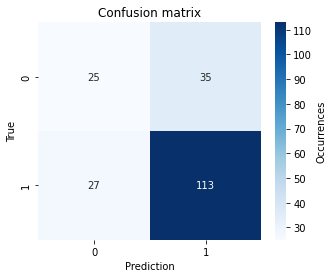

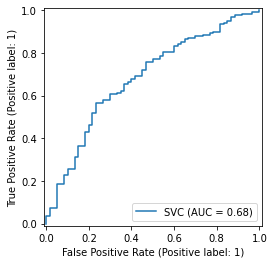

In [ ]:
#### From the Cross-Validation analysis I take the best classifier and test it over the Test set
print(f'Using classifier : {best_clf_name()}')
clf_final = best_clf_name(**best_clf.best_params_)
clf_final.fit(X_PCA, y_res)
y_pred = clf_final.predict(X_test_PCA)

#### Classification report
print(classification_report(y_test, y_pred))

#### Get the confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)

#### Visualize the confusion matrix (representing the correct/not correct predictions)
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

#### ROC Curve
RocCurveDisplay.from_estimator(clf_final, X_test_PCA, y_test)
plt.show()

#### Neural Network

In [ ]:
loss_test_all = []
acc_test_all = []
epochs = 100000
current_max_acc = 0
cnt = 0

#### set a random seed 
torch.seed()

#### initialize the model with the corresponding parameters
#### 3 hidden layers
model = Model_classification_multi(
    in_features = X_train_t.shape[-1], 
    out_features = np.unique(y_train).shape[0], 
    hidden_1 = best_mode["n_nodes"], 
    hidden_2 = best_mode["n_nodes"],
    hidden_3 = best_mode["n_nodes"],
    act=best_mode['act']
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=best_mode["lr"])
epoch = 0

while(True):
    
    # model training phase
    model.train()
    y_prob = model(X_train_t).squeeze() # get the output probability of predictions
    loss = loss_fn(y_prob, y_train_t) # calculate the loss
    optimizer.zero_grad() # reset the gradients of model parameters
    loss.backward() # backpropagate the prediction loss
    optimizer.step() # adjust the parameters by the gradients

    # model evaluation phase
    model.eval()

    # validation set
    y_prob = model(X_val_t).squeeze()
    loss_val = loss_fn(y_prob, y_val_t) 
    y_pred = torch.argmax(y_prob, dim=-1) 
    acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

    # collect results
    loss_val_all.append(loss_val.item())
    loss_test_all.append(loss_test.item())
    acc_val_all.append(acc_val)
    acc_test_all.append(acc_test)

    if (epoch%50 == 0):
        print(f'Epoch: {epoch} | Validation Loss: {loss_val:.3f}, Validation Accuracy: {acc_val:.3f}')

    epoch += 1

    if current_max_acc -  acc_val < 0: 
        current_max_acc =  acc_val
    else:
        if (epoch > 1100):
            break

print(f'After {epoch} epochs Validation Accuracy is {acc_val:.3f}')
print(f'Best Validation Accuracy: {current_max_acc:.3f}')

Epoch: 0 | Validation Loss: 0.680, Validation Accuracy: 0.736
Epoch: 50 | Validation Loss: 0.490, Validation Accuracy: 0.814
Epoch: 100 | Validation Loss: 0.482, Validation Accuracy: 0.829
Epoch: 150 | Validation Loss: 0.488, Validation Accuracy: 0.825
Epoch: 200 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 250 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 300 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 350 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 400 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 450 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 500 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 550 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 600 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 650 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 700 | Validation Loss: 0.500, Validation Accuracy: 0.811
Epoch: 750 | Validation Loss: 0.500, Valida


The accuracy of validation set is: 0.811
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       140
           1       0.83      0.78      0.80       140

    accuracy                           0.81       280
   macro avg       0.81      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280



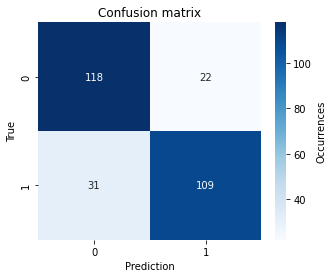

In [ ]:
#### Validation set
model.eval()
y_prob = model(X_val_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)
print(f'\nThe accuracy of validation set is: {acc_val:.3f}')
print(classification_report(y_val_t, y_pred))
confusion = confusion_matrix(y_val_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


The accuracy of test set is: 0.650
              precision    recall  f1-score   support

           0       0.43      0.52      0.47        60
           1       0.77      0.71      0.74       140

    accuracy                           0.65       200
   macro avg       0.60      0.61      0.60       200
weighted avg       0.67      0.65      0.66       200



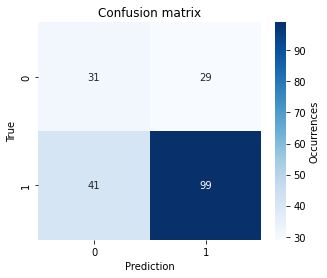

In [ ]:
#### Test set
model.eval()
y_prob = model(X_test_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)
print(f'\nThe accuracy of test set is: {acc_test:.3f}')
print(classification_report(y_test_t, y_pred))
confusion = confusion_matrix(y_test_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

# 4 Adversarial Attack #

### 4.1 Adding Random Noise

Results with Noise Level=0


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   0                   1                   0   
557                   0                   0                   0   
217                   0                   0                   1   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   1   
285                   1                   0                   0   
659                   0                   0                   0   
856                   0                   1                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   1                   0   
557                   1                   1                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   0   
285                   0                   0                   1   
659                   1                   0                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   0                   0                   0            0   
557                   0                   0                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            1   
665                   0                   0                   1            0   
285                   0                   0                   0            1   
659                   0                   0                   1            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         0         1   
627  ...             1             0         0         0         1         0   
169  ...             1             0         0         0         1         0   
557  ...             1             0         0         1         0         0   
217  ...             1             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         1         0         0   
665  ...             1             0         0         0         0         1   
285  ...             1             0         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             1             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               1               0                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   1                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   1   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   0  ...             1             0         0         0   
169                   0  ...             1             0         0         0   
557                   0  ...             1             0         0         1   
217                   1  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         1   
665                   1  ...             1             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             1             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         1               0               1                    1   
627         1         0               1               0                    0   
169         1         0               0               1                    1   
557         0         0               0               1                    0   
217         1         0               1               0                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    1   
665         0         1               1               0                    1   
285         0         0               0               1                    1   
659         1         0               0               1                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.38      0.42      0.40        60
           1       0.74      0.71      0.73       140

    accuracy                           0.62       200
   macro avg       0.56      0.57      0.56       200
weighted avg       0.63      0.62      0.63       200



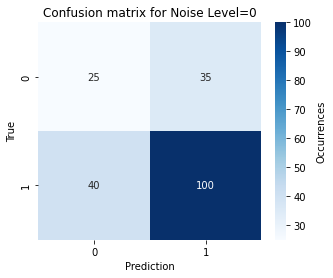

Results with Noise Level=5


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   0                   1                   0   
557                   0                   0                   0   
217                   0                   0                   1   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   1   
285                   1                   0                   0   
659                   0                   0                   0   
856                   0                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   1                   0   
557                   1                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   0   
285                   0                   0                   1   
659                   1                   0                   0   
856                   1                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   0                   0                   0            0   
557                   0                   1                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            1   
665                   0                   0                   1            0   
285                   0                   0                   0            1   
659                   0                   0                   1            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         0         1   
627  ...             1             0         0         0         1         0   
169  ...             1             0         0         0         1         0   
557  ...             1             0         0         1         0         0   
217  ...             1             0         0         1         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         1         0         0   
665  ...             1             0         0         0         0         1   
285  ...             1             0         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             1             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               1               0                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   1                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   0  ...             1             0         0         0   
169                   0  ...             1             0         0         0   
557                   0  ...             1             0         0         1   
217                   1  ...             1             0         0         1   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         1   
665                   1  ...             1             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             1             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         1               0               1                    1   
627         1         0               1               0                    0   
169         1         0               0               1                    1   
557         0         0               0               1                    0   
217         0         0               1               0                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    1   
665         0         1               1               0                    1   
285         0         0               0               1                    1   
659         1         0               0               1                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.41      0.40      0.41        60
           1       0.75      0.76      0.75       140

    accuracy                           0.65       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.65      0.65      0.65       200



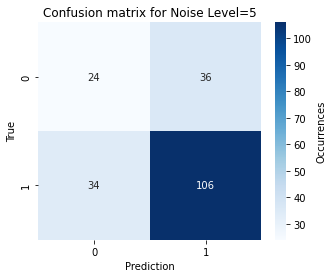

Results with Noise Level=10


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   0                   1                   0   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   1   
285                   1                   0                   0   
659                   0                   0                   0   
856                   0                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   1                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   0   
285                   0                   1                   0   
659                   1                   0                   0   
856                   1                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   1                   0                   0            0   
557                   0                   0                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            1   
665                   0                   0                   1            0   
285                   0                   0                   0            1   
659                   0                   0                   1            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         1         0         0         0   
627  ...             1             0         0         0         1         0   
169  ...             1             0         1         0         0         0   
557  ...             1             0         0         0         0         1   
217  ...             1             0         0         1         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         1         0         0   
665  ...             1             0         0         0         0         1   
285  ...             1             0         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             1             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               1               0                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   1                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         1         0   
627                   0  ...             1             0         0         0   
169                   0  ...             1             0         1         0   
557                   0  ...             1             0         0         0   
217                   0  ...             1             0         0         1   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         1   
665                   1  ...             1             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             1             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         0               0               1                    1   
627         1         0               1               0                    0   
169         0         0               0               1                    1   
557         0         1               0               1                    0   
217         0         0               1               0                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    1   
665         0         1               1               0                    1   
285         0         0               0               1                    1   
659         1         0               0               1                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.41      0.35      0.38        60
           1       0.74      0.79      0.76       140

    accuracy                           0.66       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.64      0.66      0.65       200



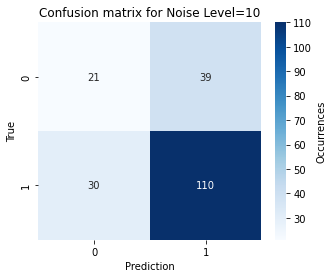

Results with Noise Level=15


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   0                   1                   0   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   1   
285                   0                   1                   0   
659                   0                   0                   0   
856                   0                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   1                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   0                   0   
856                   1                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   1                   0                   0            0   
557                   0                   0                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            1   
665                   0                   0                   1            0   
285                   0                   0                   1            0   
659                   0                   0                   1            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             1             0         0         0         1         0   
169  ...             0             0         1         0         0         0   
557  ...             0             0         0         0         0         1   
217  ...             1             0         1         0         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         0         1         0   
665  ...             1             0         0         0         0         1   
285  ...             1             0         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             1             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               0               1                    0                    1  
169               0               1                    1                    0  
557               1               0                    1                    0  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   1                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   0  ...             1             0         0         0   
169                   0  ...             0             0         1         0   
557                   0  ...             0             0         0         0   
217                   0  ...             1             0         1         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         0   
665                   1  ...             1             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             1             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    1   
627         1         0               0               1                    0   
169         0         0               0               1                    1   
557         0         1               1               0                    1   
217         0         0               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         1         0               0               1                    1   
665         0         1               1               0                    1   
285         0         0               0               1                    1   
659         1         0               1               0                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    0  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.37      0.32      0.34        60
           1       0.72      0.76      0.74       140

    accuracy                           0.63       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.62      0.63      0.62       200



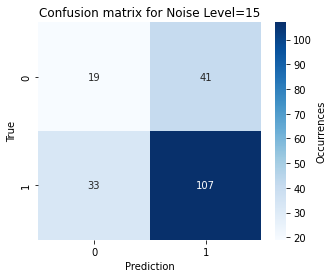

Results with Noise Level=20


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   1                   0                   0   
557                   0                   1                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   1   
285                   0                   1                   0   
659                   0                   0                   0   
856                   1                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   0                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   0                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   0                   0                   1            0   
557                   0                   0                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            0   
665                   0                   0                   1            0   
285                   0                   0                   1            0   
659                   0                   1                   0            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             1             0         1         0         0         0   
169  ...             0             0         1         0         0         0   
557  ...             0             0         0         0         0         1   
217  ...             1             0         0         1         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         0         1         0   
665  ...             1             0         0         0         0         1   
285  ...             1             0         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             1             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               0               1                    0                    1  
169               0               1                    1                    0  
557               1               0                    1                    0  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   1                   0   
557    0.333333               0.0                   0                   1   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   1                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   1                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   0  ...             1             0         1         0   
169                   0  ...             0             0         1         0   
557                   0  ...             0             0         0         0   
217                   0  ...             1             0         0         1   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         0   
665                   1  ...             1             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             1             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    1   
627         0         0               0               1                    0   
169         0         0               0               1                    1   
557         0         1               1               0                    1   
217         0         0               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         1         0               0               1                    1   
665         0         1               1               0                    1   
285         0         0               0               1                    1   
659         1         0               1               0                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    0  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.29      0.23      0.26        60
           1       0.70      0.76      0.73       140

    accuracy                           0.60       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.58      0.60      0.59       200



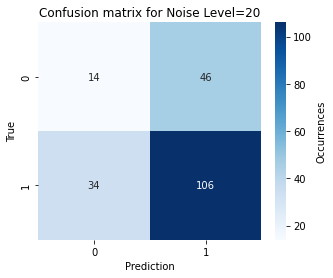

Results with Noise Level=25


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   1                   0                   0   
557                   0                   1                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   1   
285                   0                   1                   0   
659                   0                   0                   0   
856                   1                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   0                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   0                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   0                   0                   1            0   
557                   0                   0                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            0   
665                   0                   0                   1            0   
285                   0                   1                   0            0   
659                   1                   0                   0            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             0             0         0         0         0         1   
169  ...             0             0         0         0         0         1   
557  ...             0             0         0         0         0         1   
217  ...             1             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             1         0         0         1         0   
665  ...             1             0         0         0         0         1   
285  ...             1             0         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             0             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    0                    1  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   1                   0   
557    0.333333               0.0                   0                   1   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   1                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   1                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   0  ...             0             0         0         0   
169                   0  ...             0             0         0         0   
557                   0  ...             0             0         0         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             1         0         0   
665                   1  ...             1             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             0             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    0   
627         0         1               1               0                    0   
169         0         1               0               1                    1   
557         0         1               0               1                    0   
217         1         0               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         1         0               0               1                    0   
665         0         1               1               0                    1   
285         0         0               1               0                    1   
659         1         0               1               0                    1   
856         1         0               1               0                    0   

     foreign_worker_A202  
496                    1  
627                    1  
169                    0  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.31      0.27      0.29        60
           1       0.70      0.75      0.73       140

    accuracy                           0.60       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.59      0.60      0.60       200



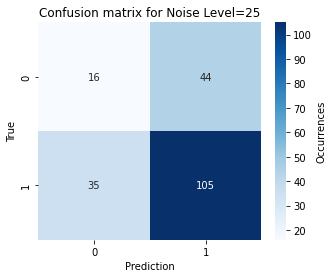

Results with Noise Level=30


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   1                   0                   0   
169                   1                   0                   0   
557                   0                   1                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   1   
285                   0                   1                   0   
659                   0                   0                   0   
856                   0                   1                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   0                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   0                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            0   
169                   1                   0                   0            0   
557                   0                   0                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            0   
665                   1                   0                   0            0   
285                   1                   0                   0            0   
659                   1                   0                   0            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             0         0         0         1         0   
627  ...             0             0         0         0         0         1   
169  ...             0             0         0         0         0         1   
557  ...             0             0         0         0         0         1   
217  ...             1             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             1         0         0         1         0   
665  ...             1             0         0         0         0         1   
285  ...             0             1         0         1         0         0   
659  ...             0             0         0         0         1         0   
856  ...             0             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    0                    1  
627               1               0                    0                    1  
169               1               0                    1                    0  
557               0               1                    1                    0  
217               1               0                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   1                   0   
557    0.333333               0.0                   0                   1   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   1                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   1   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             0             0         0         0   
627                   0  ...             0             0         0         0   
169                   0  ...             0             0         0         0   
557                   0  ...             0             0         0         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             1         0         0   
665                   1  ...             1             0         0         0   
285                   0  ...             0             1         0         1   
659                   0  ...             0             0         0         0   
856                   0  ...             0             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               1               0                    0   
627         0         1               1               0                    0   
169         0         1               1               0                    1   
557         0         1               0               1                    1   
217         1         0               1               0                    0   
..        ...       ...             ...             ...                  ...   
379         1         0               0               1                    0   
665         0         1               1               0                    1   
285         0         0               1               0                    1   
659         1         0               1               0                    1   
856         1         0               1               0                    1   

     foreign_worker_A202  
496                    1  
627                    1  
169                    0  
557                    0  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.32      0.23      0.27        60
           1       0.71      0.79      0.74       140

    accuracy                           0.62       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.59      0.62      0.60       200



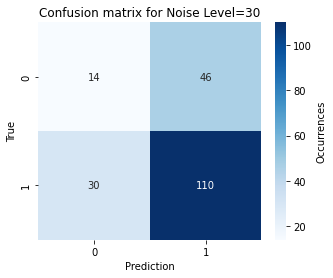

Results with Noise Level=35


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   0                   1                   0   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   1                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   1   
285                   0                   1                   0   
659                   0                   0                   0   
856                   0                   0                   1   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   1                   0                   0   
557                   1                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   1                   0   
665                   0                   0                   0   
285                   0                   0                   1   
659                   1                   0                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            0   
169                   0                   1                   0            0   
557                   0                   1                   0            1   
217                   1                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   0            0   
665                   0                   1                   0            0   
285                   0                   0                   0            0   
659                   0                   1                   0            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             0         0         0         1         0   
627  ...             0             0         0         0         0         1   
169  ...             0             0         0         0         0         1   
557  ...             1             0         0         0         0         1   
217  ...             1             0         0         0         0         1   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             0         0         1         0         0   
665  ...             0             1         0         0         1         0   
285  ...             1             0         0         1         0         0   
659  ...             1             0         0         0         1         0   
856  ...             0             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    0                    1  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    1                    0  
217               1               0                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   0                   1   
169    0.333333               0.0                   0                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   1   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             0             0         0         0   
627                   0  ...             0             0         0         0   
169                   0  ...             0             0         0         0   
557                   0  ...             1             0         0         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             0         0         1   
665                   1  ...             0             1         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             1             0         0         0   
856                   1  ...             0             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               1               0                    0   
627         0         1               1               0                    0   
169         0         1               0               1                    1   
557         0         1               0               1                    1   
217         0         1               1               0                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               0               1                    0   
665         1         0               1               0                    1   
285         0         0               1               0                    1   
659         1         0               1               0                    1   
856         1         0               1               0                    1   

     foreign_worker_A202  
496                    1  
627                    1  
169                    0  
557                    0  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.45      0.33      0.38        60
           1       0.74      0.83      0.78       140

    accuracy                           0.68       200
   macro avg       0.60      0.58      0.58       200
weighted avg       0.66      0.68      0.66       200



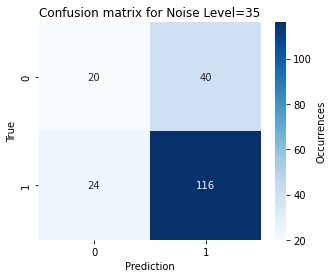

Results with Noise Level=40


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   1   
627                   0                   1                   0   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   1                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   0                   0                   0   
285                   0                   1                   0   
659                   0                   1                   0   
856                   0                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   1                   0   
169                   1                   0                   0   
557                   1                   0                   0   
217                   0                   1                   0   
..                  ...                 ...                 ...   
379                   0                   0                   1   
665                   1                   1                   0   
285                   0                   0                   1   
659                   0                   0                   0   
856                   1                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            0   
169                   0                   1                   0            0   
557                   0                   1                   0            0   
217                   0                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   0            0   
665                   0                   0                   0            0   
285                   0                   0                   0            0   
659                   0                   1                   0            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             0             0         0         0         1         0   
169  ...             0             0         0         0         0         1   
557  ...             0             0         0         0         1         0   
217  ...             1             0         0         0         0         1   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             0         0         1         0         0   
665  ...             0             0         0         0         1         0   
285  ...             1             0         0         1         0         0   
659  ...             1             0         1         0         0         0   
856  ...             0             0         0         0         0         1   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    1                    0  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               0               1                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   0                   1   
169    0.333333               0.0                   0                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   1   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   1   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   1   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   1  ...             1             0         0         0   
627                   0  ...             0             0         0         0   
169                   0  ...             0             0         0         0   
557                   0  ...             0             0         0         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             0         0         1   
665                   0  ...             0             0         0         0   
285                   0  ...             1             0         0         1   
659                   0  ...             1             0         1         0   
856                   0  ...             0             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               1               0                    1   
627         1         0               1               0                    0   
169         0         1               0               1                    1   
557         1         0               0               1                    0   
217         0         1               0               1                    0   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    1   
665         1         0               0               1                    0   
285         0         0               1               0                    0   
659         0         0               1               0                    0   
856         0         1               0               1                    1   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    1  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.27      0.20      0.23        60
           1       0.69      0.77      0.73       140

    accuracy                           0.60       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.57      0.60      0.58       200



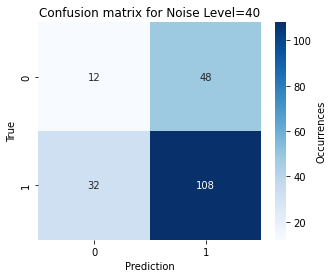

Results with Noise Level=45


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   1   
627                   0                   1                   0   
169                   0                   1                   0   
557                   0                   0                   0   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   0                   0                   0   
285                   0                   1                   0   
659                   0                   1                   0   
856                   0                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   0   
169                   0                   0                   0   
557                   1                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   1   
665                   1                   0                   0   
285                   0                   0                   1   
659                   0                   0                   0   
856                   1                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            1   
627                   0                   0                   1            0   
169                   0                   1                   0            0   
557                   0                   1                   0            0   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   0            0   
665                   0                   1                   0            0   
285                   0                   0                   0            0   
659                   0                   1                   0            0   
856                   1                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             0             0         0         0         1         0   
169  ...             0             0         0         0         0         1   
557  ...             0             0         0         0         1         0   
217  ...             0             1         0         0         0         1   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             1         0         1         0         0   
665  ...             0             1         0         1         0         0   
285  ...             1             0         0         1         0         0   
659  ...             1             0         1         0         0         0   
856  ...             0             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   0                   1   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   1                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   1   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   1   
659    0.000000               0.0                   0                   1   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   1  ...             1             0         0         0   
627                   0  ...             0             0         0         0   
169                   0  ...             0             0         0         0   
557                   0  ...             0             0         0         0   
217                   0  ...             0             1         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             1         0         1   
665                   0  ...             0             1         0         1   
285                   0  ...             1             0         0         1   
659                   0  ...             1             0         1         0   
856                   0  ...             0             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    1   
627         1         0               1               0                    0   
169         0         1               0               1                    1   
557         1         0               0               1                    0   
217         0         1               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    0   
665         0         0               0               1                    0   
285         0         0               0               1                    1   
659         0         0               1               0                    1   
856         1         0               0               1                    1   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.34      0.25      0.29        60
           1       0.71      0.79      0.75       140

    accuracy                           0.63       200
   macro avg       0.53      0.52      0.52       200
weighted avg       0.60      0.63      0.61       200



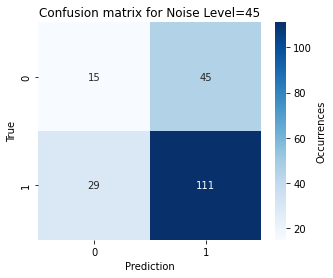

Results with Noise Level=50


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   1   
627                   0                   1                   0   
169                   0                   1                   0   
557                   1                   0                   0   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   1   
285                   0                   0                   0   
659                   0                   1                   0   
856                   0                   0                   1   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   1                   0   
169                   0                   0                   0   
557                   0                   0                   1   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   1                   0                   1   
659                   0                   0                   0   
856                   0                   1                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   0            1   
169                   1                   0                   0            0   
557                   0                   0                   0            0   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   1                   0            0   
665                   0                   1                   0            0   
285                   0                   0                   0            0   
659                   0                   1                   0            0   
856                   0                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             0         0         0         1         0   
627  ...             0             0         1         0         0         0   
169  ...             0             0         0         1         0         0   
557  ...             0             1         0         0         1         0   
217  ...             0             1         1         0         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         0         0         1   
665  ...             0             1         0         0         0         1   
285  ...             1             0         0         0         1         0   
659  ...             1             0         1         0         0         0   
856  ...             0             1         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               0               1                    1                    0  
169               0               1                    0                    1  
557               1               0                    0                    1  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   0                   1   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   1                   0   
217    0.000000               0.0                   1                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   1                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   0                   1   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   1  ...             0             0         0         0   
627                   0  ...             0             0         1         0   
169                   0  ...             0             0         0         1   
557                   0  ...             0             1         0         0   
217                   0  ...             0             1         1         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         0   
665                   1  ...             0             1         0         0   
285                   0  ...             1             0         0         0   
659                   0  ...             1             0         1         0   
856                   1  ...             0             1         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    1   
627         0         0               0               1                    1   
169         0         0               0               1                    0   
557         1         0               1               0                    0   
217         0         0               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         0         1               0               1                    0   
665         0         1               0               1                    1   
285         1         0               1               0                    1   
659         0         0               1               0                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    0  
627                    0  
169                    1  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.47      0.30      0.37        60
           1       0.74      0.86      0.79       140

    accuracy                           0.69       200
   macro avg       0.61      0.58      0.58       200
weighted avg       0.66      0.69      0.67       200



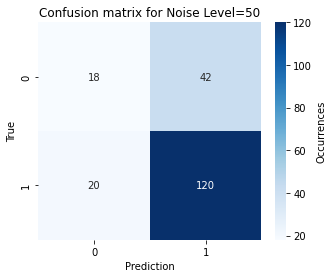

Results with Noise Level=55


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   0                   0                   0   
169                   0                   1                   0   
557                   0                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   0                   0                   1   
285                   0                   0                   0   
659                   0                   0                   0   
856                   0                   1                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   1                   0                   0   
169                   0                   0                   0   
557                   0                   0                   1   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   1                   0                   0   
659                   1                   0                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   0                   1            0   
627                   1                   0                   0            0   
169                   1                   0                   0            0   
557                   0                   0                   0            0   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   1                   0            0   
665                   0                   1                   0            0   
285                   0                   0                   1            1   
659                   0                   1                   0            0   
856                   0                   0                   1            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         1         0         0         0   
627  ...             0             0         1         0         0         0   
169  ...             0             1         0         0         1         0   
557  ...             0             0         0         0         1         0   
217  ...             0             1         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             0         0         1         0         0   
665  ...             0             0         0         0         1         0   
285  ...             1             0         1         0         0         0   
659  ...             1             0         0         0         1         0   
856  ...             0             0         0         1         0         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    0                    1  
627               1               0                    0                    1  
169               0               1                    1                    0  
557               0               1                    0                    1  
217               1               0                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   0                   0   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   1                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   1   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   1   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         1         0   
627                   0  ...             0             0         1         0   
169                   0  ...             0             1         0         0   
557                   1  ...             0             0         0         0   
217                   0  ...             0             1         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             0         0         1   
665                   1  ...             0             0         0         0   
285                   0  ...             1             0         1         0   
659                   0  ...             1             0         0         0   
856                   0  ...             0             0         0         1   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         0               0               1                    0   
627         0         0               1               0                    0   
169         1         0               0               1                    1   
557         1         0               0               1                    0   
217         1         0               1               0                    0   
..        ...       ...             ...             ...                  ...   
379         0         0               0               1                    1   
665         1         0               0               1                    1   
285         0         0               0               1                    0   
659         1         0               1               0                    1   
856         0         0               1               0                    1   

     foreign_worker_A202  
496                    1  
627                    1  
169                    0  
557                    1  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.36      0.23      0.28        60
           1       0.71      0.82      0.76       140

    accuracy                           0.65       200
   macro avg       0.54      0.53      0.52       200
weighted avg       0.61      0.65      0.62       200



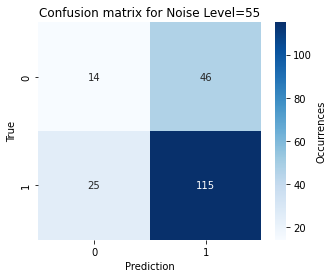

Results with Noise Level=60


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   1   
627                   1                   0                   0   
169                   0                   0                   1   
557                   0                   0                   1   
217                   0                   1                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   0                   0                   0   
285                   1                   0                   0   
659                   0                   0                   1   
856                   0                   1                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   1                   0                   0   
285                   0                   0                   0   
659                   0                   1                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   0                   1            0   
627                   0                   0                   0            0   
169                   0                   1                   0            0   
557                   0                   0                   1            0   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            0   
665                   0                   1                   0            1   
285                   0                   0                   1            0   
659                   0                   0                   0            1   
856                   0                   0                   1            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             1             0         0         0         1         0   
169  ...             0             0         0         0         0         1   
557  ...             0             1         1         0         0         0   
217  ...             1             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         1         0         0   
665  ...             0             1         0         0         1         0   
285  ...             0             0         0         0         1         0   
659  ...             0             1         0         0         1         0   
856  ...             0             0         0         1         0         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    0                    1  
627               1               0                    1                    0  
169               0               1                    1                    0  
557               1               0                    1                    0  
217               0               1                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   1   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   1   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   1                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   1   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   1  ...             1             0         0         0   
627                   0  ...             1             0         0         0   
169                   1  ...             0             0         0         0   
557                   1  ...             0             1         1         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         0         1   
665                   0  ...             0             1         0         0   
285                   0  ...             0             0         0         0   
659                   1  ...             0             1         0         0   
856                   0  ...             0             0         0         1   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               1               0                    0   
627         1         0               1               0                    1   
169         0         1               0               1                    1   
557         0         0               1               0                    1   
217         1         0               0               1                    0   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    1   
665         1         0               1               0                    0   
285         1         0               0               1                    1   
659         1         0               0               1                    1   
856         0         0               0               1                    0   

     foreign_worker_A202  
496                    1  
627                    0  
169                    0  
557                    0  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.25      0.13      0.17        60
           1       0.69      0.83      0.75       140

    accuracy                           0.62       200
   macro avg       0.47      0.48      0.46       200
weighted avg       0.56      0.62      0.58       200



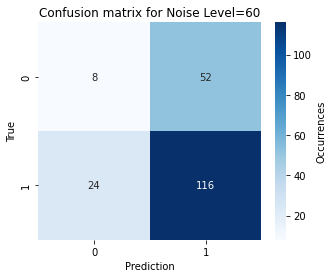

Results with Noise Level=65


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   1   
627                   1                   0                   0   
169                   0                   1                   0   
557                   1                   0                   0   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   1   
285                   1                   0                   0   
659                   0                   0                   0   
856                   0                   1                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   1   
627                   0                   1                   0   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   1                   0   
856                   0                   0                   1   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   0                   0            0   
627                   0                   0                   0            1   
169                   0                   0                   1            0   
557                   0                   1                   0            0   
217                   0                   0                   1            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            0   
665                   0                   1                   0            0   
285                   0                   0                   1            0   
659                   0                   0                   0            1   
856                   0                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             1         0         1         0         0   
627  ...             1             0         0         0         1         0   
169  ...             1             0         0         0         1         0   
557  ...             0             1         0         0         0         1   
217  ...             1             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             1         0         0         0         1   
665  ...             1             0         0         0         1         0   
285  ...             0             1         0         0         0         1   
659  ...             1             0         0         0         1         0   
856  ...             0             1         0         1         0         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               1               0                    1                    0  
169               0               1                    0                    1  
557               0               1                    1                    0  
217               1               0                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   1                   0   
217    0.000000               0.0                   1                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   1                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   1   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   1  ...             0             1         0         1   
627                   0  ...             1             0         0         0   
169                   0  ...             1             0         0         0   
557                   0  ...             0             1         0         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             1         0         0   
665                   1  ...             1             0         0         0   
285                   0  ...             0             1         0         0   
659                   0  ...             1             0         0         0   
856                   0  ...             0             1         0         1   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         0               0               1                    1   
627         1         0               1               0                    1   
169         1         0               0               1                    0   
557         0         1               0               1                    1   
217         1         0               1               0                    1   
..        ...       ...             ...             ...                  ...   
379         0         1               0               1                    0   
665         1         0               0               1                    0   
285         0         1               1               0                    1   
659         1         0               1               0                    1   
856         0         0               0               1                    1   

     foreign_worker_A202  
496                    0  
627                    0  
169                    1  
557                    0  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.26      0.15      0.19        60
           1       0.69      0.81      0.75       140

    accuracy                           0.61       200
   macro avg       0.47      0.48      0.47       200
weighted avg       0.56      0.61      0.58       200



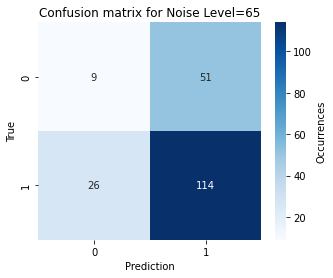

Results with Noise Level=70


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   0   
627                   1                   0                   0   
169                   0                   0                   0   
557                   0                   0                   1   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   1   
665                   0                   1                   0   
285                   0                   0                   0   
659                   0                   0                   1   
856                   1                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   1                   0                   0   
627                   0                   0                   0   
169                   1                   0                   1   
557                   0                   0                   0   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   1                   0   
285                   1                   0                   0   
659                   0                   1                   0   
856                   0                   0                   1   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   1                   0                   0            0   
169                   0                   0                   0            0   
557                   0                   0                   1            1   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   1                   0                   0            0   
665                   0                   0                   0            0   
285                   1                   0                   0            0   
659                   0                   0                   0            0   
856                   0                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         1         0         0         0   
627  ...             0             0         0         0         0         1   
169  ...             1             0         1         0         0         0   
557  ...             0             0         1         0         0         0   
217  ...             0             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         1         0         0         0   
665  ...             0             0         0         0         1         0   
285  ...             0             0         0         0         0         1   
659  ...             0             0         1         0         0         0   
856  ...             1             0         1         0         0         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    1                    0  
627               0               1                    0                    1  
169               1               0                    1                    0  
557               1               0                    1                    0  
217               1               0                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   1                   0   
169    0.333333               0.0                   0                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   1   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   1                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         1         0   
627                   0  ...             0             0         0         0   
169                   0  ...             1             0         1         0   
557                   1  ...             0             0         1         0   
217                   0  ...             0             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   1  ...             1             0         1         0   
665                   0  ...             0             0         0         0   
285                   0  ...             0             0         0         0   
659                   1  ...             0             0         1         0   
856                   0  ...             1             0         1         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         0               0               1                    1   
627         0         1               0               1                    0   
169         0         0               1               0                    1   
557         0         0               1               0                    1   
217         1         0               1               0                    0   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    0   
665         1         0               1               0                    0   
285         0         1               0               1                    0   
659         0         0               1               0                    0   
856         0         0               1               0                    0   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    0  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.26      0.15      0.19        60
           1       0.69      0.82      0.75       140

    accuracy                           0.62       200
   macro avg       0.48      0.49      0.47       200
weighted avg       0.56      0.62      0.58       200



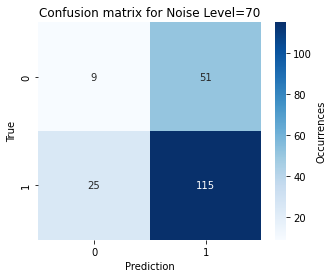

Results with Noise Level=75


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   1   
627                   0                   0                   0   
169                   0                   0                   1   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   0                   0                   0   
285                   0                   0                   1   
659                   1                   0                   0   
856                   1                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   1                   0                   0   
169                   0                   0                   1   
557                   1                   1                   0   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   1                   0                   1   
285                   0                   0                   0   
659                   0                   0                   1   
856                   0                   0                   1   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   1                   0            0   
627                   1                   0                   0            0   
169                   0                   0                   0            0   
557                   0                   0                   0            0   
217                   0                   0                   1            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   1            1   
665                   0                   0                   0            0   
285                   0                   0                   1            0   
659                   0                   0                   0            0   
856                   0                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             0         0         0         1         0   
627  ...             1             0         0         1         0         0   
169  ...             0             1         1         0         0         0   
557  ...             1             0         0         1         0         0   
217  ...             0             0         1         0         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             1         1         0         0         0   
665  ...             1             0         0         1         0         0   
285  ...             1             0         0         0         0         1   
659  ...             1             0         0         0         1         0   
856  ...             0             1         0         0         0         1   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    0                    1  
627               1               0                    1                    0  
169               0               1                    0                    1  
557               0               1                    0                    1  
217               1               0                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   0                   0   
169    0.333333               0.0                   0                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   1   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   1                   0   
856    0.000000               0.0                   1                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   1  ...             0             0         0         0   
627                   0  ...             1             0         0         1   
169                   1  ...             0             1         1         0   
557                   0  ...             1             0         0         1   
217                   0  ...             0             0         1         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             1         1         0   
665                   0  ...             1             0         0         1   
285                   1  ...             1             0         0         0   
659                   0  ...             1             0         0         0   
856                   0  ...             0             1         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               1               0                    0   
627         0         0               1               0                    1   
169         0         0               0               1                    0   
557         0         0               0               1                    0   
217         0         0               1               0                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               0               1                    0   
665         0         0               1               0                    0   
285         0         1               1               0                    1   
659         1         0               0               1                    1   
856         0         1               1               0                    0   

     foreign_worker_A202  
496                    1  
627                    0  
169                    1  
557                    1  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.27      0.17      0.21        60
           1       0.69      0.81      0.75       140

    accuracy                           0.61       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.57      0.61      0.58       200



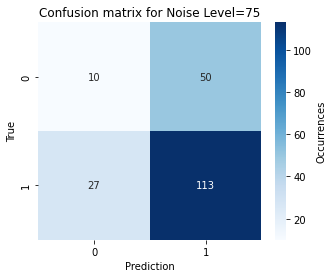

Results with Noise Level=80


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   0                   0                   1   
169                   1                   0                   0   
557                   0                   0                   1   
217                   1                   0                   0   
..                  ...                 ...                 ...   
379                   0                   0                   1   
665                   0                   1                   0   
285                   0                   0                   1   
659                   0                   0                   1   
856                   0                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   1                   0   
627                   0                   0                   0   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   0                   0                   1   
285                   0                   0                   0   
659                   0                   0                   0   
856                   1                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   0                   0            0   
627                   0                   1                   0            1   
169                   0                   1                   0            1   
557                   1                   0                   0            0   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   0            0   
665                   0                   0                   0            0   
285                   1                   0                   0            0   
659                   0                   1                   0            0   
856                   0                   0                   1            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         1         0   
627  ...             0             1         0         1         0         0   
169  ...             0             0         0         0         1         0   
557  ...             0             0         0         0         1         0   
217  ...             1             0         0         0         1         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         0         0         0         1   
665  ...             0             1         1         0         0         0   
285  ...             0             1         0         1         0         0   
659  ...             0             1         1         0         0         0   
856  ...             0             0         1         0         0         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    1                    0  
627               0               1                    0                    1  
169               1               0                    1                    0  
557               1               0                    1                    0  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   0                   0   
169    0.333333               0.0                   1                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   1                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   1   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   1  ...             0             1         0         1   
169                   0  ...             0             0         0         0   
557                   1  ...             0             0         0         0   
217                   0  ...             1             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   1  ...             1             0         0         0   
665                   0  ...             0             1         1         0   
285                   1  ...             0             1         0         1   
659                   1  ...             0             1         1         0   
856                   0  ...             0             0         1         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               1               0                    1   
627         0         0               0               1                    0   
169         1         0               1               0                    1   
557         1         0               1               0                    1   
217         1         0               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         0         1               1               0                    1   
665         0         0               0               1                    1   
285         0         0               0               1                    0   
659         0         0               1               0                    0   
856         0         0               1               0                    1   

     foreign_worker_A202  
496                    0  
627                    1  
169                    0  
557                    0  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.23      0.13      0.17        60
           1       0.68      0.81      0.74       140

    accuracy                           0.60       200
   macro avg       0.46      0.47      0.45       200
weighted avg       0.55      0.60      0.57       200



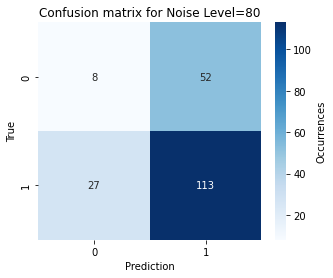

Results with Noise Level=85


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   0   
627                   0                   1                   0   
169                   0                   1                   0   
557                   0                   0                   1   
217                   0                   0                   1   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   1                   0                   0   
285                   0                   0                   1   
659                   0                   0                   0   
856                   0                   0                   1   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   1                   0                   0   
627                   0                   0                   1   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   0                   1   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   0                   0   
856                   0                   0                   1   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   0                   1            0   
627                   0                   0                   0            0   
169                   1                   0                   0            0   
557                   0                   0                   1            0   
217                   0                   0                   0            0   
..                  ...                 ...                 ...          ...   
379                   1                   0                   0            0   
665                   0                   0                   1            0   
285                   0                   1                   0            0   
659                   0                   0                   1            0   
856                   0                   0                   0            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             1         0         0         1         0   
627  ...             0             1         0         0         0         1   
169  ...             0             0         1         0         0         0   
557  ...             1             0         1         0         0         0   
217  ...             1             0         1         0         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             0         1         0         0         0   
665  ...             1             0         0         0         1         0   
285  ...             1             0         0         1         0         0   
659  ...             1             0         0         0         0         1   
856  ...             1             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    0                    1  
627               1               0                    1                    0  
169               1               0                    0                    1  
557               0               1                    0                    1  
217               1               0                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   0                   1   
169    0.333333               0.0                   0                   1   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   1   
665    0.333333               0.0                   1                   0   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             0             1         0         0   
627                   0  ...             0             1         0         0   
169                   0  ...             0             0         1         0   
557                   1  ...             1             0         1         0   
217                   1  ...             1             0         1         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             0             0         1         0   
665                   0  ...             1             0         0         0   
285                   1  ...             1             0         0         1   
659                   0  ...             1             0         0         0   
856                   1  ...             1             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    0   
627         0         1               1               0                    1   
169         0         0               1               0                    0   
557         0         0               0               1                    0   
217         0         0               1               0                    0   
..        ...       ...             ...             ...                  ...   
379         0         0               1               0                    0   
665         1         0               1               0                    0   
285         0         0               1               0                    1   
659         0         1               0               1                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    1  
627                    0  
169                    1  
557                    1  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.23      0.17      0.19        60
           1       0.68      0.76      0.72       140

    accuracy                           0.58       200
   macro avg       0.46      0.47      0.46       200
weighted avg       0.55      0.58      0.56       200



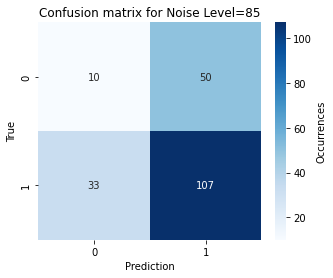

Results with Noise Level=90


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   1                   0   
627                   0                   0                   1   
169                   1                   0                   0   
557                   0                   0                   1   
217                   0                   1                   0   
..                  ...                 ...                 ...   
379                   0                   0                   0   
665                   0                   0                   0   
285                   0                   0                   1   
659                   0                   0                   1   
856                   0                   1                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   0                   0                   0   
627                   0                   0                   0   
169                   0                   0                   0   
557                   0                   0                   0   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   1                   0                   0   
665                   1                   0                   1   
285                   0                   1                   0   
659                   0                   0                   1   
856                   0                   0                   1   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   1                   0                   0            0   
627                   0                   0                   1            0   
169                   0                   1                   0            0   
557                   1                   0                   0            0   
217                   0                   1                   0            0   
..                  ...                 ...                 ...          ...   
379                   1                   0                   0            0   
665                   0                   0                   0            0   
285                   0                   0                   0            1   
659                   0                   0                   0            0   
856                   0                   0                   0            1   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             1             0         0         0         0         1   
627  ...             0             0         1         0         0         0   
169  ...             0             0         0         0         1         0   
557  ...             0             0         0         0         1         0   
217  ...             0             0         0         0         0         1   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             1             0         1         0         0         0   
665  ...             0             1         0         1         0         0   
285  ...             0             1         1         0         0         0   
659  ...             0             1         0         0         0         1   
856  ...             0             1         1         0         0         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               1               0                    1                    0  
627               0               1                    1                    0  
169               0               1                    1                    0  
557               0               1                    1                    0  
217               0               1                    1                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   1   
627    0.000000               0.0                   0                   0   
169    0.333333               0.0                   1                   0   
557    0.333333               0.0                   0                   0   
217    0.000000               0.0                   0                   1   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   0                   0   
856    0.000000               0.0                   0                   1   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             1             0         0         0   
627                   1  ...             0             0         1         0   
169                   0  ...             0             0         0         0   
557                   1  ...             0             0         0         0   
217                   0  ...             0             0         0         0   
..                  ...  ...           ...           ...       ...       ...   
379                   0  ...             1             0         1         0   
665                   0  ...             0             1         0         1   
285                   1  ...             0             1         1         0   
659                   1  ...             0             1         0         0   
856                   0  ...             0             1         1         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         0         1               1               0                    1   
627         0         0               0               1                    1   
169         1         0               0               1                    1   
557         1         0               0               1                    1   
217         0         1               0               1                    1   
..        ...       ...             ...             ...                  ...   
379         0         0               0               1                    1   
665         0         0               1               0                    1   
285         0         0               0               1                    0   
659         0         1               0               1                    0   
856         0         0               1               0                    1   

     foreign_worker_A202  
496                    0  
627                    0  
169                    0  
557                    0  
217                    0  
..                   ..

              precision    recall  f1-score   support

           0       0.34      0.22      0.27        60
           1       0.71      0.82      0.76       140

    accuracy                           0.64       200
   macro avg       0.53      0.52      0.51       200
weighted avg       0.60      0.64      0.61       200



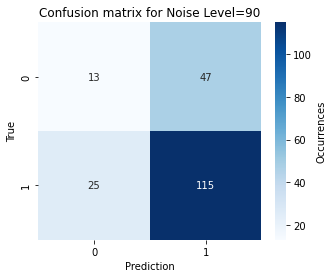

Results with Noise Level=95


Status_account_A11  Status_account_A12  Status_account_A13  \
496                   0                   0                   0   
627                   0                   1                   0   
169                   0                   0                   1   
557                   1                   0                   0   
217                   0                   0                   1   
..                  ...                 ...                 ...   
379                   0                   0                   1   
665                   0                   0                   0   
285                   0                   0                   0   
659                   1                   0                   0   
856                   1                   0                   0   

     Status_account_A14  Credit_history_A30  Credit_history_A31  \
496                   1                   0                   0   
627                   0                   1                   0   
169                   0                   0                   1   
557                   0                   0                   1   
217                   0                   0                   0   
..                  ...                 ...                 ...   
379                   0                   1                   0   
665                   1                   0                   0   
285                   1                   0                   1   
659                   0                   1                   0   
856                   0                   0                   0   

     Credit_history_A32  Credit_history_A33  Credit_history_A34  Purpose_A40  \
496                   0                   0                   1            0   
627                   0                   0                   0            1   
169                   0                   0                   0            0   
557                   0                   0                   0            0   
217                   0                   0                   1            0   
..                  ...                 ...                 ...          ...   
379                   0                   0                   0            0   
665                   0                   0                   1            1   
285                   0                   0                   0            0   
659                   0                   0                   0            0   
856                   0                   0                   1            0   

     ...  Housing_A152  Housing_A153  Job_A171  Job_A172  Job_A173  Job_A174  \
496  ...             0             1         0         0         1         0   
627  ...             1             0         1         0         0         0   
169  ...             1             0         0         1         0         0   
557  ...             1             0         0         0         0         1   
217  ...             0             1         0         1         0         0   
..   ...           ...           ...       ...       ...       ...       ...   
379  ...             0             1         0         0         1         0   
665  ...             1             0         0         0         1         0   
285  ...             0             0         0         1         0         0   
659  ...             0             0         0         1         0         0   
856  ...             0             0         0         0         1         0   

     Telephone_A191  Telephone_A192  foreign_worker_A201  foreign_worker_A202  
496               0               1                    0                    1  
627               1               0                    0                    1  
169               1               0                    0                    1  
557               1               0                    0                    1  
217               1               0                    0                 

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  
496    0.000000               0.0  
627    0.000000               0.0  
169    0.333333               0.0  
557    0.333333               0.0  
217    0.000000               0.0  
..          ...               ...  
379    0.333333               0.0  
665    0.333333               0.0  
285    0.000000               0.0  
659    0.000000               0.0  
856    0.000000               0.0  

[200 rows x 7 columns]

Duration  Credit_amount  Install_rate  Present_residence_since       Age  \
496  0.727273       0.567106      1.000000                 0.000000  0.181818   
627  0.113636       0.071671      0.333333                 0.666667  0.181818   
169  0.454545       0.104148      1.000000                 1.000000  0.218182   
557  0.386364       0.304226      0.000000                 1.000000  0.181818   
217  0.727273       0.233142      0.333333                 0.333333  0.072727   
..        ...            ...           ...                      ...       ...   
379  0.045455       0.001565      1.000000                 1.000000  0.600000   
665  0.454545       0.389722      1.000000                 0.333333  0.145455   
285  0.977273       0.677188      0.000000                 0.000000  0.290909   
659  0.318182       0.392787      0.333333                 0.000000  0.400000   
856  0.136364       0.036259      1.000000                 0.666667  0.381818   

     No_credits  No_people_liable  Status_account_A11  Status_account_A12  \
496    0.000000               0.0                   0                   0   
627    0.000000               0.0                   0                   1   
169    0.333333               0.0                   0                   0   
557    0.333333               0.0                   1                   0   
217    0.000000               0.0                   0                   0   
..          ...               ...                 ...                 ...   
379    0.333333               0.0                   0                   0   
665    0.333333               0.0                   0                   0   
285    0.000000               0.0                   0                   0   
659    0.000000               0.0                   1                   0   
856    0.000000               0.0                   1                   0   

     Status_account_A13  ...  Housing_A152  Housing_A153  Job_A171  Job_A172  \
496                   0  ...             0             1         0         0   
627                   0  ...             1             0         1         0   
169                   1  ...             1             0         0         1   
557                   0  ...             1             0         0         0   
217                   1  ...             0             1         0         1   
..                  ...  ...           ...           ...       ...       ...   
379                   1  ...             0             1         0         0   
665                   0  ...             1             0         0         0   
285                   0  ...             0             0         0         1   
659                   0  ...             0             0         0         1   
856                   0  ...             0             0         0         0   

     Job_A173  Job_A174  Telephone_A191  Telephone_A192  foreign_worker_A201  \
496         1         0               0               1                    0   
627         0         0               1               0                    0   
169         0         0               1               0                    0   
557         0         1               1               0                    0   
217         0         0               1               0                    0   
..        ...       ...             ...             ...                  ...   
379         1         0               1               0                    0   
665         1         0               0               1                    0   
285         0         0               1               0                    1   
659         0         0               1               0                    1   
856         1         0               0               1                    0   

     foreign_worker_A202  
496                    1  
627                    1  
169                    1  
557                    1  
217                    1  
..                   ..

              precision    recall  f1-score   support

           0       0.33      0.23      0.27        60
           1       0.71      0.79      0.75       140

    accuracy                           0.62       200
   macro avg       0.52      0.51      0.51       200
weighted avg       0.59      0.62      0.60       200



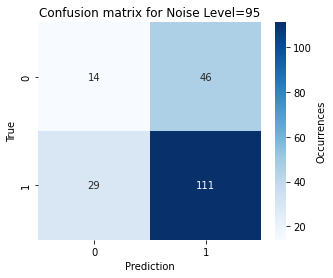

Text(0.5, 0, 'Noise Level')

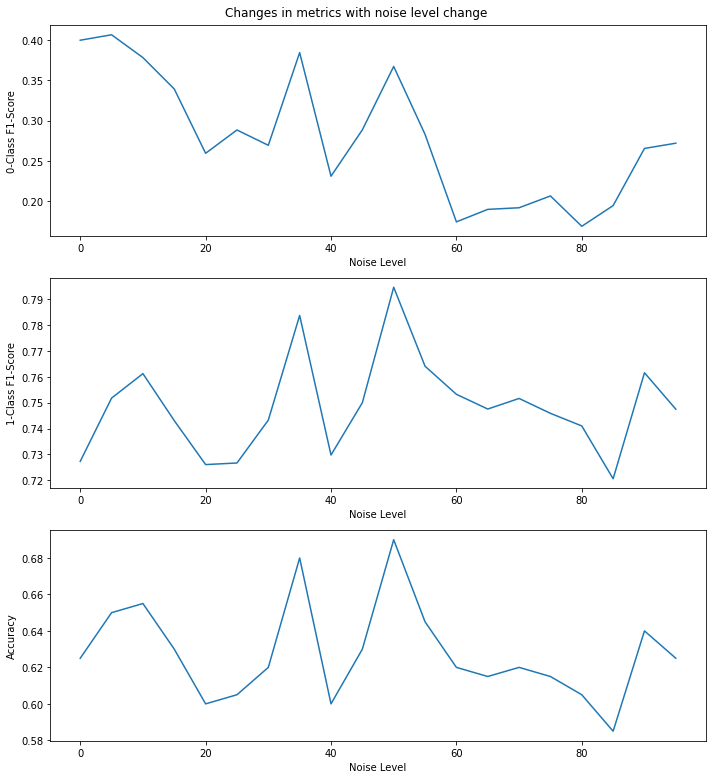

In [ ]:
# Function to add noise to numerical data
def add_noise_with_norm_clipping(data, columns, norm_threshold):

    # Generate random noise with the same shape as the data
    noise = np.random.normal(size=data[columns].shape)
    noise = pd.DataFrame(noise, index=data.index, columns=to_remove)

    # Calculate the Euclidean norm of the noise
    noise_norm = np.linalg.norm(noise)

    # Clip the noise to have a certain Euclidean norm
    if noise_norm > norm_threshold:
        noise = noise * (norm_threshold / noise_norm)

    # Add noise to the data
    temp = data[columns].copy()
    temp = temp + noise
    return data

# Function to add noise to categorical data
def add_noise_to_categorical(df, columns, noise_level):

    for column in columns:
        unique_values = df[column].unique()
        num_samples = int(len(df) * noise_level * 0.01) # Noise Level between 0 and 100 meaning percentage of dataset to change
        indices_to_change = np.random.choice(df.index, num_samples, replace=False)

        for idx in indices_to_change:
            current_value = df.at[idx, column]
            new_value = np.random.choice(unique_values)

            # Ensure the new value is different from the current value
            while new_value == current_value:
                new_value = np.random.choice(unique_values)

            df.at[idx, column] = new_value
    
    return df

accuracy = {}
# Specify the maximum Noise Level for the added noise
for noise_level in range(0, 100, 5):
    
    print(f'Results with Noise Level={noise_level}')

    # Add noise with a certain in noise level
    cat_Noisy = add_noise_to_categorical(X_test_not_encoded, to_be_encoded, noise_level).drop([col for col in num_Noisy.columns if col in to_remove], axis=1)
    cat_Noisy = pd.get_dummies(cat_Noisy, columns=to_be_encoded, dtype = int)
    
    # Add noise to the data with Euclidean norm clipping
    num_Noisy = add_noise_with_norm_clipping(X_test.copy(), to_remove, noise_level)
    num_Noisy = num_Noisy.drop([col for col in num_Noisy.columns if col not in to_remove], axis=1)
    num_Noisy.index = cat_Noisy.index

    X_test_noisy = pd.concat([num_Noisy, cat_Noisy], axis=1)
    X_test_noisy = pca.transform(X_test_noisy)

    X_noisy_t = torch.tensor(X_test_noisy, dtype=torch.float)

    #### Test set
    model.eval()
    y_prob = model(X_noisy_t).squeeze()
    y_pred = torch.argmax(y_prob, dim=-1) 
    report = classification_report(y_test_t, y_pred, output_dict=True)
    print(classification_report(y_test_t, y_pred))
    accuracy[noise_level] = report
    confusion = confusion_matrix(y_test_t, y_pred)

    #### Visualize the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'Confusion matrix for Noise Level={noise_level}')
    plt.show()

fig, axs = plt.subplots(3,figsize=(10,11), tight_layout=True)
fig.suptitle('Changes in metrics with noise level change')

values=[]
for value in accuracy.values():
    values.append(value['0']['f1-score'])
axs[0].plot(accuracy.keys(), values)
axs[0].set_ylabel('0-Class F1-Score')
axs[0].set_xlabel('Noise Level')

values=[]
for value in accuracy.values():
    values.append(value['1']['f1-score'])
axs[1].plot(accuracy.keys(), values)
axs[1].set_ylabel('1-Class F1-Score')
axs[1].set_xlabel('Noise Level')

values=[]
for value in accuracy.values():
    values.append(value['accuracy'])
axs[2].plot(accuracy.keys(), values)
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Noise Level')


### 4.2

### 4.3 Adversarial Attack using ART

In [ ]:

classifier = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=X_train_t.shape[-1],
    nb_classes=2,
    clip_values=(0, 1)
)


In [ ]:
## Attack 1: Fast Gradient Method (FGM)
#fgm = FastGradientMethod(estimator=classifier, eps=0.2)
#x_test_adv_fgm = []
#y_test_adv_fgm = []
#for images, labels in test_loader:
#    x_test_adv_fgm.append(fgm.generate(x=images.numpy()))
#    y_test_adv_fgm.append(labels.numpy())
#x_test_adv_fgm = np.vstack(x_test_adv_fgm)
#y_test_adv_fgm = np.hstack(y_test_adv_fgm)
#fgm_accuracy = np.sum(np.argmax(classifier.predict(x_test_adv_fgm), axis=1) == y_test_adv_fgm) / len(y_test_adv_fgm)
#print(f'Accuracy on FGM adversarial test data: {fgm_accuracy * 100:.2f}%')
#

In [ ]:
## Attack 2: Projected Gradient Descent (PGD)
#pgd = ProjectedGradientDescent(estimator=classifier, eps=0.2, eps_step=0.01, max_iter=40)
#x_test_adv_pgd = []
#y_test_adv_pgd = []
#for images, labels in test_loader:
#    x_test_adv_pgd.append(pgd.generate(x=images.numpy()))
#    y_test_adv_pgd.append(labels.numpy())
#x_test_adv_pgd = np.vstack(x_test_adv_pgd)
#y_test_adv_pgd = np.hstack(y_test_adv_pgd)
#pgd_accuracy = np.sum(np.argmax(classifier.predict(x_test_adv_pgd), axis=1) == y_test_adv_pgd) / len(y_test_adv_pgd)
#print(f'Accuracy on PGD adversarial test data: {pgd_accuracy * 100:.2f}%')


### 4.4 Countermeasures Exploration